# MRI Brain Tumor Detection & classification System

## What is brain tumor?

Brain tumors are abnormal growth of cells that will arise within the brain or its surrounding tissues. They can be classiffied majorly into benign(noncancerous) and malignant(cacerous) tumors.

The tumor in brain disrupt the normal brain fuction by pressing on vital areas which often leads to symptoms such as headachs and seizures.

Each year, an estimated 3540 children under the age of fifteen are diagnosed with brain tumors which highlighting the importance of early detection and intervention.

Source: https://www.sciencedirect.com/science/article/pii/S2405844024128046


## Problem statement

Brain tumors are life threatening and require early and accurate dignosis to improve patient survival and outcome.
Manual interpretation of MRI scans by radiologists is required and important but it is also time consuming many be subjected to human error.
By developing a deep learning based system to automatically detect and classify tumor(including identifying tumor type), I can help automate the diagnosis process which will reduce the workload for clinicians and in turn improve the accuracy in imaging analysis.
This project aim to distinguish between no tumor and several tumor types(such as glioma, meningioma and pituitary), supporting more precise treatment planning for doctors.

##Dataset collection and preparation

The dataset i am using in this project contains MRI images of the human brain which is basically categorized into four given classes:

- Glioma
-  Meningioma
-  Pituitary
- No Tumor

The dataset is furthur organized into two main subsets each containing all four categories:
1. Training Set: Used to train the model and help it learn tumor specific patterns.
2. Testing Set: Used to evaluate how well the model performs on completely unseen data.


For this project, I am following an efficient method to access the dataset compared to what I used in previous assignments. Earlier, I would manually download the dataset from Kaggle, upload it to my Google Drive and then mount Drive inside Colab which took extra time and storage.
This time, I used the Kaggle API directly inside Colab. I went to my Kaggle account settings > generated the kaggle.json API key > uploaded it into the Colab environment.

After setting the correct permissions, I was able to download and extract the Brain Tumor MRI dataset automatically with just a few commands,without any manual steps.

This approach is much faster, cleaner, and better cause I do not need to upload the dataset again and again unlike the previous naive method I used.

I learned this method from a Kaggle discussion: https://www.kaggle.com/discussions/general/74235

Kaggle DataSet Link which I used in this Assignment is given Below:

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [ ]:
#Install Kaggle API to download datasets directly from Kaggle
!pip install -q kaggle

# --- Set up Kaggle API credentials ---
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json #giving proper permissions

# --- Download the Brain Tumor MRI dataset from Kaggle ---
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

# --- unzip the dataset into a folder ---
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

print(" Dataset downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.60GB/s]
 Dataset downloaded and extracted successfully!


##Importing libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

##Load Dataset into (Train / Validation / Test)

In [ ]:
# --- Directories for training and testing data --------
train_dir = "/content/brain-tumor-mri-dataset/Training"
test_dir  = "/content/brain-tumor-mri-dataset/Testing"

img_size = (224, 224)
batch_size = 32

# --- Train + Validation split ----------------
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    label_mode="categorical",
    batch_size=batch_size,
    validation_split=0.2,      # Meaning 20% validation
    subset="training",
    seed=42
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    label_mode="categorical", #labels will returned as one-hot encoded vectors (e.g., [1,0,0,0]).
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

#----------------------------------------------------------
# --- Test data (no split) ----------------------
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    label_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

# --- Class names ---
class_names = train_data.class_names
print("Classes:", class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


I split my dataset into 80% training and 20% validation with a completely separate test set cause there was no Validation dataset given in kaggle. Since the overall dataset is small, using an 80:20 split gives the model enough images to learn from while still keeping a decent amount for validation. This balance helps the model learn better without overfitting i think and the separate test set allows me to evaluate the final performance on data the model has never seen before.

When TensorFlow splits the dataset into training and validation sets, it does this randomly thats why i used the seed function. If I dont set a seed, the split will be different every time the moment i execute the code. That means different images would end up in the training set and validation set on each run, which would cause the model’s accuracy to change unpredictably. It becomes harder to compare results or understand whether a model actually improved or getting degraded. By fixing the seed to 42, I make the split consistent every run uses the exact same images for training and the same images for validation. This makes the results stable ad much more easier to reproduce.

--------------------------------------------------------
Resource 1: Official Keras API Documentation

https://keras.io/api/data_loading/image/

For validation_split, setting the same seed in both training and validation to ensure the split is consistent across runs.

--------------------------------------------------------
Resource 2: discussed in Chapter 5 (“Machine Learning Basics”) and Chapter 7 (“Regularization”) of Deep Learning by Goodfellow, Bengio, and Courville (MIT Press, 2016)

He explains that for small datasets, using 80/20 or 70/30 is the standard and most reliable split.

https://aikosh.indiaai.gov.in/static/Deep+Learning+Ian+Goodfellow.pdf

For the images, I resized everything to 224x224, because most pretrained CNN models such as ResNet, VGG, DenseNet, and EfficientNet are designed to take 224x224 inputs. Using this size keeps the model compatible with transfer learning and also provides a good balance between detail in the MRI scans and computational efficiency.

--------------------------------------------------------
Resource 3: ResNet Original Paper & documentation (He et al., 2015)

Uses 224x224 input images trained on ImageNet.

https://keras.io/api/applications/resnet/#resnet50-function

I chose a batch size of 32 because it is one of the most commonly used and stable batch sizes in deep learning. It works well with GPU memory limits (especially in Colab) and research shows that smaller batch sizes like 32 usually provide better generalization than very large batches.

--------------------------------------------------------
Resource 4: Empirical studies such as a Weights & Biases report on “Whats the Optimal Batch Size to Train a Neural Network?”

observe that small batch sizes around 32 can give better validation performance than very large batches, and highlight that larger batches, while faster per epoch, often generalize worse

https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU



##looking at some sample images from the Dataset

To visualize a few sample images from my training dataset, I took one batch from train_data and converted the one- hot encoded labels back into class indices using np.argmax(), because TensorFlow returns labels in one-hot encoded form, so each label is a vector like [0, 1, 0, 0].

To convert this into a class index {0, 1, 2 or 3}, I used np.argmax() along axis 1. This function finds the position of the 1 in each label vector.

I later use this index to map it to the actual class name from class_names. I then displayed the first nine images in a 3x3 grid, turning each tensor into a normal uint8 image for correct color representation and adding the corresponding class name above each image.

This visualization helped verify that the images are loaded correctly and that each image is matched with the correct label before training the model. Using one-hot encoding is a good standard especially for multi class classification because it represents each class as a binary vector and works well with softmax output layers.

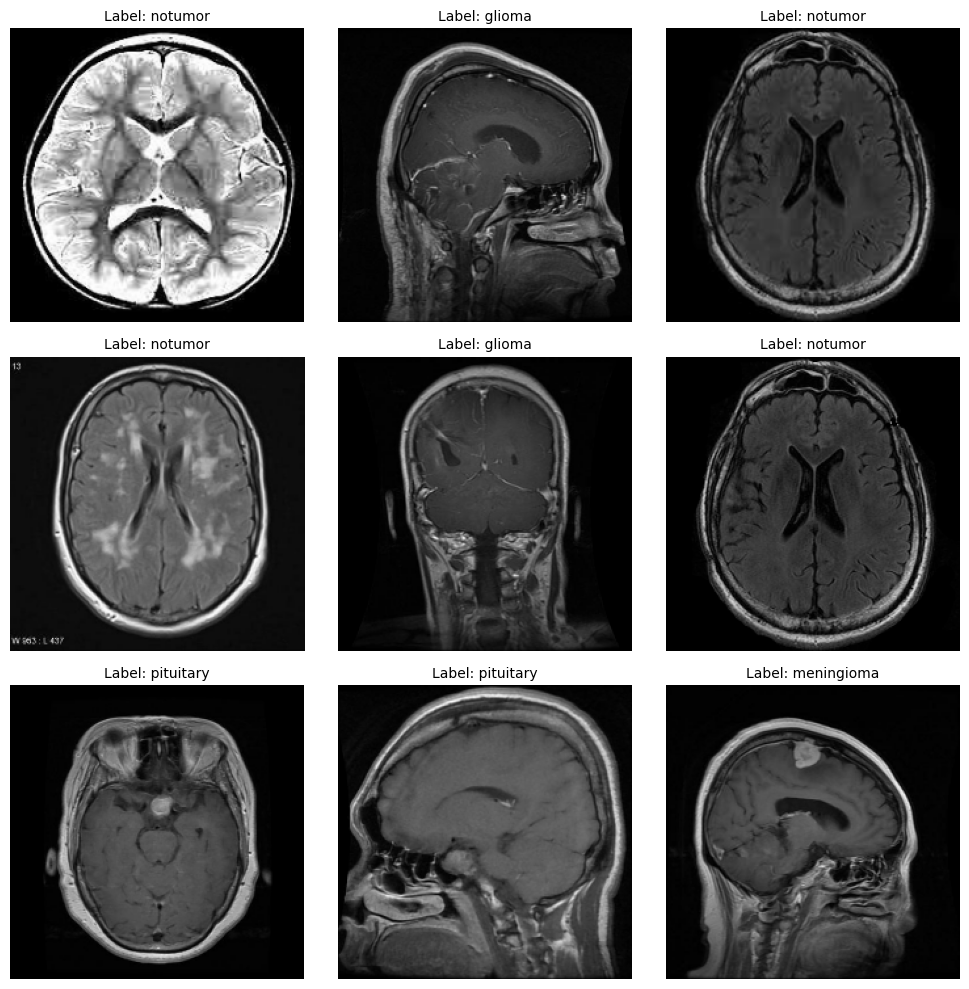

In [ ]:
plt.figure(figsize=(10, 10))

#Taking a batch from training data
for images, labels in train_data.take(1):

    #Convert categorical one-hot labels-> class index
    label_indices = np.argmax(labels.numpy(), axis=1)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        #Display image
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        class_label = class_names[label_indices[i]]
        plt.title(f"Label: {class_label}", fontsize=10)

plt.tight_layout()
plt.show()

#ResNet50: My initial transfer learning approach

I chose ResNet50 because it is one of the most reliable and widely used CNN architectures for image classification especially when working with medical images.

ResNet is known for its use of skip connections(residual blocks) which solve the vanishing gradient problem.  

Since my dataset is relatively small, using a pretrained model like ResNet50 is a big advantage because it already knows how to extract important visual
patterns from millions of images(ImageNet).

While ImageNet pretraining does not guarantee perfect feature transfer for medical images, it generallly provides a strong starting point and helps reduce the risk of overfitting when combined with proper data augmentation and regularization.

Also, ResNet50 also has a good balance between complexity and performance it is powerful but still effficient enough to train on Collab without running into memory issues.

### 1. Preparing images for training

I prepared all MRI images so they match the input format expected by the ResNet50 model. I used the official preprocess_input() function which handles image normalization by adjusting pixel values in the exact way ResNet50 was trained on during ImageNet pretraining.

This step is important because pretrained models depend on a specific input distribution, and feeding raw pixel values would reduce accuracy. After applying this preprocessing function to the training, validation, and test sets, I used .cache() to speed up training by storing processed batches in memory and .prefetch() to load the next batch while the current one is being processed.

In [ ]:
# PREPROCESSING
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_res

def preprocess_resnet(image, label):
    return preprocess_res(image), label

train_res = train_data.map(preprocess_resnet).cache().prefetch(tf.data.AUTOTUNE)
val_res   = val_data.map(preprocess_resnet).cache().prefetch(tf.data.AUTOTUNE)
test_res  = test_data.map(preprocess_resnet).cache().prefetch(tf.data.AUTOTUNE)

### 2. ResNet50 as the Baseline Model

In [ ]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
base_resnet.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = base_resnet(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

resnet_model = models.Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Here, I built my baseline transfer learning model using ResNet50, a well-known deep CNN architecture pretrained on ImageNet. I loaded ResNet50 without its top classification layers (include_top=False) because I wanted to use it only as a feature extractor for my MRI dataset. I also set trainable=False to freeze all the pretrained weights so that the model keeps the powerful visual features it already learned and trains faster on my smaller medical dataset.

The Next thing I did is I added my own classification head on top of the frozen base: a GlobalAveragePooling2D layer to reduce the feature maps these feature maps contain extracted pattterns like edges, shapes, textures and tumor related structures, too large to directly feed into a Dense layer .so a Dense(256, ReLU) layer to learn high level tumor patterns, a Dropout(0.5) layer to prevent overfitting,  every training step uses a slightly different version of the network, which makes the model learn patterns that generalize better to new, unseen images. and a final Dense(4, Softmax) output layer for my four tumor classes. Before softmax, the model might output values like {2.3, 0.8, -1.1, 3.5}, which dont mean anything by themselves. Softmax transforms these numbers into a probability distribution such as {0.12, 0.03, 0.01, 0.84}. These values now represent how confident the model is about each tumor type, and they always add up to 1.0 (100%).

This structure lets ResNet50 extract strong image features while the custom layers adapt the model specifically to brain tumor classification. Overall, this forms a solid baseline model before fine tuning.

### 3. Compiling ResNet50 with categorical cross-entropy

In this part, I compiled my ResNet50 baseline model using the Adam optimizer and categorical cross-entropy loss. Adam adjusts learning rates per weight based on gradient estimates. It usually gives good results without needing much tunning, while categorical cross-entropy is because my problem has four classes, and my labels are one-hot encoded like this [1, 0, 0, 0] or [0, 0, 1, 0].
This loss function is made exactly for comparing these one hot labels with the models softmax predictions, so this loss function fits good for multi-class classification.. After compilling, I printed the model summary to confirm that the architecture was built correctly.

The model consists of a frozen ResNet50 backbone for feature extraction followed by my custom classification layers: a GlobalAveragePooling layer, a Dense layer with ReLU activation, a Dropout layer to reduce overfitting, and a final softmax output layer for predicting the tumor class.

In [ ]:
# FIXED LOSS (BECAUSE LABELS ARE CATEGORICAL)
resnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Output summary

The model summary matches exactly what I built in the code. It shows that the whole network has around 24.1 million parameters, but only the small set of layers I added at the end Dense(256), Dropout(0.5), and Dense(4) are being trained (about 525k parameters). The large chunk of parameters, about 23.58 million, comes from the ResNet50 backbone, which I froze in my code using:

base_resnet.trainable = False

This is why the summary lists them as non-trainable parameters.
The output shapes in the summary also match the structure of my code.
When I pass the input image into ResNet50:

x = base_resnet(inputs, training=False)

it produces a feature map of size 7 x 7 x 2048, which the summary shows as:
(None, 7, 7, 2048)
Then I used a GlobalAveragePooling layer:

x = layers.GlobalAveragePooling2D()(x)
and in the summary this becomes:

(None, 2048)
After that, the dense and dropout layers appear exactly as I defined:

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

The summary confirms these layers have the shapes (None, 256) and (None, 4).
Finally, the last Dense(4) layer produces four values, one for each tumor class, which is exactly what the softmax activation was meant to do.

So, The summary confirms that the architecture matches what I implemented and that only the intended layers are trainable.

Now I am setting up the training pipeline for my ResNet50 baseline model. For starters, I added an EarlyStopping callback so that training automatically stops if the validation accuracy does not improve for 5 consecutive epochs. This helps prevent overfitting and also saves time since there is no benefit in continuing to train once the model stops getting better.

I also included a ReduceLROnPlateau callback. This reduces the learning rate whenever the validation accuracy fails to improve for 3 epochs which allowing the model to slow down its updates, refining its learning and getting out of performance plateaus.

After configuring these callbacks, I trained the model using:

### 4. ResNet50 Model training with early stopping and LR Scheduling

In [ ]:
# TRAINING
early = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.8)

history_res = resnet_model.fit(
    train_res,
    validation_data=val_res,
    epochs=10,
    callbacks=[early, reduce_lr]
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.6980 - loss: 0.8327 - val_accuracy: 0.8879 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.8723 - loss: 0.3335 - val_accuracy: 0.9142 - val_loss: 0.2398 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.8960 - loss: 0.2711 - val_accuracy: 0.9186 - val_loss: 0.2098 - learning_rate: 0.0010
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.9022 - loss: 0.2406 - val_accuracy: 0.9194 - val_loss: 0.2057 - learning_rate: 0.0010
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.9061 - loss: 0.2328 - val_accuracy: 0.9291 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9204 - loss: 0.2090 - val_accuracy: 0.9221 - val_loss: 0.2066 - learning_rate: 0.0010
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9

During training, we get four main values in every epoch: accuracy, loss, val_accuracy, and val_loss. Accuracy tells us what percentage of the training images the model predicted correctly in that epoch. Loss tells us how far the models predictions are from the correct labels. A lower loss means the predictions are closer to the truth values. The validation accuracy and validation loss measure the same things but on the validation set which contains images the model never sees during training. Well this numbers show how well the model generalizes beyond the training data.

In my results, the training accuracy went up from 70 percent in the first epoch to around 95 percent by the tenth epoch. At the same time, the training loss kept going down. This means the model is learning the patterns in the training images properly. The validation accuracy also stayed high whici is around 92 to 94 % and the validation loss stayed close to the training loss. When the training and validation numbers stay close to each other and both improve, it usually means the learning process is stable.(I ignored the first value of 0.83 in acc_loss for comparison with val_loss)

The ReduceLROnPlateau callback lowered the learning rate when training started to slow down, which helped the model make smaller updates and improve a bit more. EarlyStopping did not stop the training early because the validation accuracy kept improving or stayed stable.

It seems all four metrics show that the model is learning correctly and is able to perform well on images it has not seen before.

##Trying with 15 epocs

In [ ]:
# early = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
# reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.8)

history_res = resnet_model.fit(
    train_res,
    validation_data=val_res,
    epochs=15,
    callbacks=[early, reduce_lr]
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9476 - loss: 0.1397 - val_accuracy: 0.9440 - val_loss: 0.1738 - learning_rate: 8.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.9578 - loss: 0.1278 - val_accuracy: 0.9510 - val_loss: 0.1554 - learning_rate: 8.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9595 - loss: 0.1141 - val_accuracy: 0.9457 - val_loss: 0.1672 - learning_rate: 8.0000e-04
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9587 - loss: 0.1149 - val_accuracy: 0.9492 - val_loss: 0.1484 - learning_rate: 8.0000e-04
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9587 - loss: 0.1080 - val_accuracy: 0.9475 - val_loss: 0.1543 - learning_rate: 8.0000e-04
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9634 - loss: 0.0953 - val_accuracy: 0.9571 - val_loss: 0.1415 - learning_rate: 6.4000e-04
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 10

The results from 15 epochs are very similar to the 10 epoch run. The accuracy improved only slightly after the tenth epoch as observed and the validation accuracy stayed in the same range as before.

The validation loss also showed the same pattern of small ups and downs. This means the model had already learned most of the useful patterns by around 10 epochs and the extra 5 epochs did not make a major difference in performance which we might see later.

### 5. Plot training and validation accuracy and loss

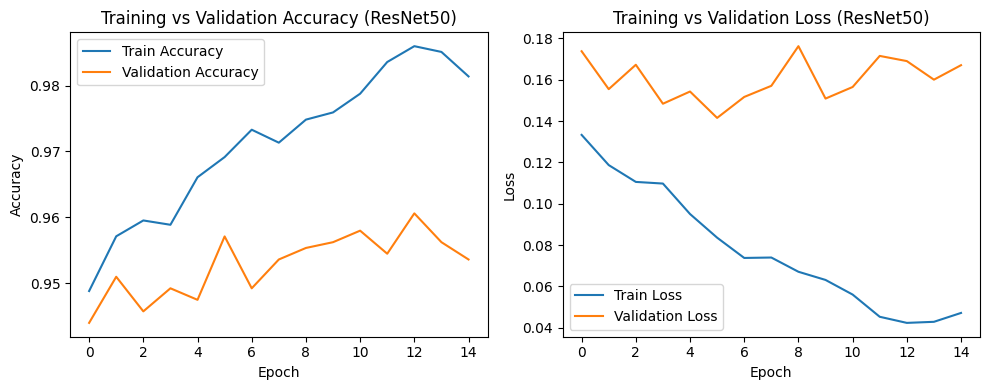

In [ ]:
plt.figure(figsize=(10,4))

# Accuracy Curve------
plt.subplot(1,2,1)
plt.plot(history_res.history['accuracy'], label='Train Accuracy')
plt.plot(history_res.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# ---- Loss Curve--------
plt.subplot(1,2,2)
plt.plot(history_res.history['loss'], label='Train Loss')
plt.plot(history_res.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (ResNet50)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###What the learning curves tell me about my model?

The accuracy graph shows that the training accuracy keeps increasing and reaches almost 99 percnt by the latter epochs. The validation accuracy stays stable in the range of 94 to 96%. This means thatt the model is learning well and is performing consistently on unseen validation images.

The training accuracy becomes higher than the validation accuracy as I wrote earlier and it is normal because the model sees the training images repeatedly.

The loss graph shows the same pattern. The training loss keeps going down, while the validation loss stays in a higher but steady range or limits. The small up and down movement in the validation loss is very normal and does not show any serious overfitting.

So, the two graphs match the 15 epoch results and confirm that the model improved smoothly these throughout training.

###How did adding more convolutional layers affect my training and validation losses

For comparison To ResNet50, I also built my own deeper CNN model from scratch.This model has several convolution layers with increasing filter sizes, followed by max pooling after each block. I stacked more convolution layers  to let the network learn more detailed patterns step by step. After convolution and pooling blocks, the model has a flatten layer and two dense layers and  final dense layer uses softmax to classify the image into one of the four tumor classes.

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

num_classes = len(class_names)

#Building a deeper CNN model
deeperModel = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # FIXED
])

# Compiling the model
deeperModel.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Training the deeper CNN model
historyDeeper = deeperModel.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.5516 - loss: 34.3151 - val_accuracy: 0.8345 - val_loss: 0.4497
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8491 - loss: 0.4431 - val_accuracy: 0.8651 - val_loss: 0.3930
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8955 - loss: 0.2895 - val_accuracy: 0.8958 - val_loss: 0.3461
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9213 - loss: 0.2018 - val_accuracy: 0.8940 - val_loss: 0.3634
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9309 - loss: 0.1779 - val_accuracy: 0.9177 - val_loss: 0.3035
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9589 - loss: 0.1297 - val_accuracy: 0.8975 - val_loss: 0.3161
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9626 - loss: 0.1028 - val_accuracy: 0.9256 - val_loss: 0.2915
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9669 - loss: 0.0832 - val_accur

The deeper CNN starts with much lower performance than the ResNet50 model. In the first epoch, the loss is extremely highher and the accuracy is around 55 percent because  model needs time to learn basic patterns. As the training continues, the training accuracy increases quickly and reaches very high values by the later epochs.

By the 5th epoch, the training accuracy had already reached about 93 percent and the training loss dropped to around 0.17, which shows that the model learned the patterns in the training set quickly for this model.

On the validation side, the accuracy steadily increased from about 83 percent in the first epoch to about 93 percent by epoch 8. This means the model was improving on unseen data during the early and middle part of training. The lowest validation loss appears around epoch 8, at about 0.27. After that point, the validation loss begins to rise again even though the validation accuracy stays between 92 and 93 percent. For example, at epoch 12, the validation loss increases to around 0.40, and by the final epoch it is around 0.40 again.

The model fits the training data extremely well, reaching more than 99 percent accuracy by the last few epochs but the validation loss increasing from around 0.27 to 0.40 for validation set which indicates that the deeper model begins to rely too much on the training set.

In simple words, the numbers show that the deeper model learns fast, reaches high accuracy and performs good but the rising validation loss after epoch 8 suggests that the model becomes less consistent on new data as training continues.

###Ploting training and validation accuracy and loss of deeper CNN

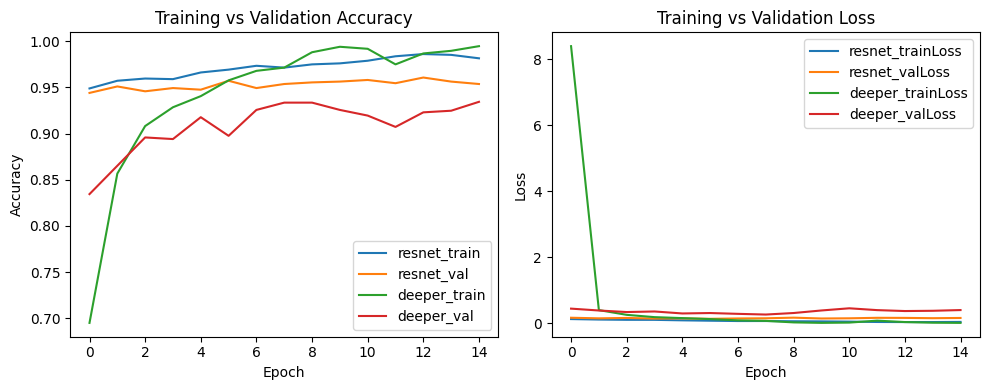

In [ ]:
plt.figure(figsize=(10,4))

# ---- AccuracyCurves ---------
plt.subplot(1,2,1)
plt.plot(history_res.history['accuracy'], label='resnet_train')
plt.plot(history_res.history['val_accuracy'], label='resnet_val')
plt.plot(historyDeeper.history['accuracy'], label='deeper_train')
plt.plot(historyDeeper.history['val_accuracy'], label='deeper_val')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# ------Loss Curves ----
plt.subplot(1,2,2)
plt.plot(history_res.history['loss'], label='resnet_trainLoss')
plt.plot(history_res.history['val_loss'], label='resnet_valLoss')
plt.plot(historyDeeper.history['loss'], label='deeper_trainLoss')
plt.plot(historyDeeper.history['val_loss'], label='deeper_valLoss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

When both models are placed side by side given above image, the difference is very clear. ResNet50 reaches a strong level of performance early and then keeps it almost unchanged. It does not get better or worse that easily after the first few epochs. This means its feature extractor is already well suited for the task, and the training mostly adjusts the last few layers. As a result, the accuracy and loss curves flatten out quickly, showing that the model has reached a stable point.

The deeper CNN behaves in the opposite way. Instead of settling, it keeps shifting as the epochs progress. The model becomes more confident on the training set but its behavior on the validation set does not settle into the same pattern. The validation curves rise and fall instead of flattening which means the model never reaches a consistent point. In other words, the deeper CNN keeps changing its internal representation even after it has already learned the main structure of the data.

From these observations, the conclusion is simple. ResNet50 reaches a steady state where both curves follow the same general trend. The deeper CNN initially did not reached that steady state. One model stabilizes, the other keeps kind of drifting.

According to me such difference alone is enough to choose ResNet50 as the more reliable option for this problem.

##Evaluating the ResNet50 Model

In [ ]:
# --- collectting true and predicted labels ---
true_res = []
pred_res = []

for images, labels in test_res:

    preds = resnet_model.predict(images)
    # Convert one-hot true labels --> class index
    true_labels = np.argmax(labels.numpy(), axis=1)

    # Convert prediction probabilities --> predicted class
    pred_labels = np.argmax(preds, axis=1)

    true_res.extend(true_labels)
    pred_res.extend(pred_labels)

# Convert to arrays
true_res = np.array(true_res)
pred_res = np.array(pred_res)

# --- Classification Report-------
print("=== ResNet50 Classification Report======")
print(classification_report(true_res, pred_res, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

- After evaluating my ResNet50 model on the unseen test dataset, I noticed that although the model performed reasonably well overall, there are still areas where it could improve.
- I extracted the true and predicted labels from the test set and used classification_report() to measure precision, recall and F1-scores for each tumor type.
- The model reached an overall accuracy of 94%, which is decent, but not perfect especially for a medical imaging task where even small mistakes matter.

- The notumor and pituitary classes stand out because the model identifies them correctly almost every time. Glioma and meningioma are a bit harder for the model, which is clear from their lower recall values.

This means the model occasionally misses these two tumor types. Anyways Even with that, all classes remain above eighty percent on every metric and the overall accuracy of 94 percent shows that the model performs strongly across the dataset.

##Confusion Matrix for the ResNet50 Model

We apply argmax() to the model’s softmax predictions because the model does not directly output a class name it only outputs probabilities for each class. For example, if the model outputs [0.10, 0.70, 0.05, 0.15], it means “70% chance this is meningioma,” so we need argmax() to pick the class with the highest probability. This converts the softmax output into a class number (like 1 for meningioma), which we can then use to compare with the true label, build the confusion matrix, and calculate performance metrics like accuracy and F1-score.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

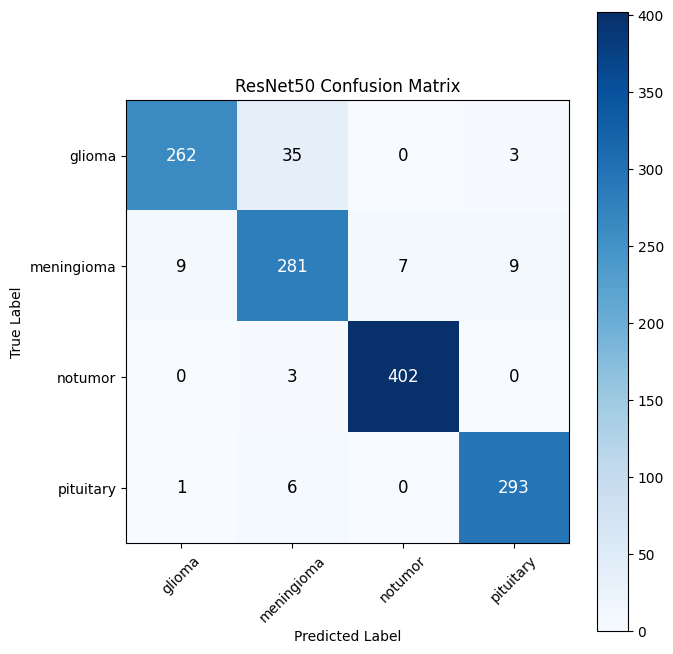

In [ ]:
#-----Recompute true + predicted labels----------
true_res = []
pred_res = []

for images, labels in test_res:
    preds = resnet_model.predict(images)

    true_labels = np.argmax(labels.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)
    true_res.extend(true_labels)
    pred_res.extend(pred_labels)

true_res = np.array(true_res)
pred_res = np.array(pred_res)

# ----------Building Confusion Matrix----------
cm = confusion_matrix(true_res, pred_res)

plt.figure(figsize=(7,7))
plt.imshow(cm, cmap="Blues")
plt.title("ResNet50 Confusion Matrix")
plt.colorbar()

# class tick marks
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, cm[i, j],
        ha="center",
        va="center",
        color="white" if cm[i, j] > cm.max() / 2 else "black",
        fontsize=12
    )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

The confusion matrix shows that my ResNet50 model is very accurate on “no tumor” and “pituitary” cases, but it makes mistakes when distinguishing between glioma and meningioma.These two tumor types look somewhat similar in MRI images so according to me the model sometimes mixes them up.

To improve this, I can fine tune some of the deeper layers of ResNet50 instead of keeping the whole model frozen and also use stronger data augmentation so the model sees more variations during training. I can also try handling class imbalance better or testing more advanced models like EfficientNet or Vision Transformers. These steps will help the model make fewer mistakes and perform more consistently across all tumor types.

##-------------------------------------------------------------------------------

#Model -2 EfficientNet-B0

###Why I Chose EfficientNet-B0 for Brain Tumor Classification

After working with ResNet50 and my own deeper CNN, I noticed that adding more layers does not always lead to better results, especially with MRI data. Traditional CNNs focus mainly on depth, but after a point, deeper networks can run into problems like vanishing gradients or simply stop improving. In some cases, making the model deeper only increases the risk of overfitting without giving any real benefit.

EfficientNet takes a different approach. Instead of increasing only the depth, it scales the network in three directions at the same time: depth, width, and input resolution. This method, called compound scaling, helps the model gain capacity in a balanced way. As a result, the network can capture detailed patterns without becoming overly large or inefficient.

Since MRI brain tumor classification requires picking up small differences between classes, especially for glioma and meningioma, I wanted a model that can extract fine features while staying compact. EfficientNet-B0 fits this need because it offers strong accuracy with a relatively small number of parameters. It improves on older CNN designs not by being extremely deep, but by being scaled in a way that keeps the model efficient and stable.

This combination of higher accuracy, better feature extraction, and lower computational cost is why I decided to move from ResNet50 to EfficientNet-B0 for the next part of the project.


Resource 1: EfficientNet Original Paper (Tan & Le, 2019)
Explains depth/width/resolution scaling and introduces compound scaling. Also shows EfficientNet outperforming ResNet and VGG.
Section 3 (compound scaling), Table 1 (accuracy comparison)
https://arxiv.org/pdf/1905.11946

Resource 2 - IJRAR Research Paper (2024)
Shows a practical use of EfficientNet-B0 and explains why compound scaling helps in medical imaging tasks.
Discusses EfficientNet-B0 architecture, benefits & performance
https://www.ijrar.org/papers/IJRAR24A3421.pdf

Resource 3 - Viso.ai Explanation of EfficientNet
Great explanation of why EfficientNet improves efficiency and accuracy across multiple scaling dimensions.
Covers scaling (depth/width/resolution) + architecture diagrams
https://viso.ai/deep-learning/efficientnet/

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 1. Downloading and Preparing the Dataset for EfficientNet-B0

Before starting the EfficientNet-B0 model, I needed to download and prepare the dataset again to keep the workflow organized and independent from my earlier ResNet50 section.

This ensures that my EfficientNet pipeline starts with a fresh and properly structured dataset in the correct directory, making it easier to run preprocessing, build the model, and evaluate its performance without mixing it with my previous ResNet model.

In [ ]:
#Step 1: downloading dataset again for EfficientNet-B0

!pip install -q kaggle
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

print("Dataset downloaded AND extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.77GB/s]
Dataset downloaded and extracted successfully!


### 2. Organizing the paths and loading the Dataset (Train / Val / Test)

This entire loading process is the same as the one I used earlier for the ResNet50 model.

In [ ]:
train_dir = "/content/brain-tumor-mri-dataset/Training"
test_dir  = "/content/brain-tumor-mri-dataset/Testing"

img_size = (224, 224)
batch_size = 32

# Load training+validation split
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

#Printing class names
class_names = train_data.class_names
print("Classes:", class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### 3. Preprocessing the MRI images for EfficientNet-B0

In [ ]:
# from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

def preprocess_efficientnet(image, label):
    return preprocess_eff(image), label

# Apply preprocessing+optimize pipeline
train_eff = train_data.map(preprocess_efficientnet).cache().prefetch(tf.data.AUTOTUNE)
val_eff = val_data.map(preprocess_efficientnet).cache().prefetch(tf.data.AUTOTUNE)
test_eff  = test_data.map(preprocess_efficientnet).cache().prefetch(tf.data.AUTOTUNE)

The expected preprocessing method for EfficientNet-B0 is different than other popular models such as VGG16 or ResNet50. EfficientNet uses its own method through the inbuilt preprocess function that normalizes images in the same way the model was trained on with ImageNet.
If I were to skip this preprocessing method and feed undeveloped raw MRI pixel values, it would not match the expected input distribution for EfficientNet-B0 resulting in a considerable decrease in performance. Therefore, I created the function preprocess_efficientnet() which extracts the correct normalized image data while preserving the original labels of the images.

The most critical component of this method is that I preprocessed the data only after splitting the data into training, validation and testing subsets. If I had preprocessed the data prior to splitting into subsets, it could create issues with the data mismatch during training validation and testing. By splitting the data first, it ensures that the training set will be independent of having ever seen preprocessed versions of the validation and test image sets.

After applying the preprocessing functions on each of the dataset subsets, I combined them with the use of .cache() and .prefetch() functions to build a highly optimized pipeline into TensorFlow.
- Using .cache() allows me to save all preprocessed batch data in memory so I do not have to recompute all of the subsequent epochs on the same data, thus drastically speeding up the model training time.
- .Prefetch() allows me to load up the next batch of data into memory while processing the current batch. Thusly, prefetch makes sure that the GPU will always have information to process.

Resource : Official Keras EfficientNet Documentation
https://keras.io/api/applications/efficientnet/

This directly supports the claim:
You must use EfficientNet’s own preprocessing because the ImageNet-trained weights expect that normalization.


### 4. Building the EfficientNet-B0 Model

In [ ]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers, models

# Load EfficientNet-B0 (without top classifier)
base_eff = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze base model so only new layers train
base_eff.trainable = False

# Building model
inputs = layers.Input(shape=(224, 224, 3))
x = base_eff(inputs, training=False)

# Optional extra Conv2D layer (helps adapt ImageNet features to MRI features)
x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)

# Final classification layer (4 tumor classes)
outputs = layers.Dense(4, activation="softmax")(x)
eff_model = models.Model(inputs, outputs)

# Compiling model
eff_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

eff_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,418,375 (16.85 MB)

 Trainable params: 368,804 (1.41 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

To build the EfficientNet-B0 model, I started by loading the pretrained EfficienttNet-B0 without its final classification layer. Removing the topmost classifier allows the model to act purely as a feature extractor since the original ImageNet labels do not match the four MRI tumor classes. I kept the EfficientNet base frozen(base_eff.trainable = False) so that its pretrained weights stay intact. Freezing is important here because my MRI dataset is much smaller than ImageNet, and updating all EfficientNet layers could easily lead to overfitting or unstable training.

Once an image passes through EfficientNet-B0, it produces a 7 by 7 by 1280 feature map. These features capture a broad range of shapes, textures, and patterns learned from ImageNet. To help the model adapt these general features to the structure of MRI images, I added one extra Conv2D layer. This small layer helps the network adjust its focus toward medical textures and tumor boundaries, which do not appear in natural images.

After this, I used a GlobalAveragePooling2D layer. Instead of flattening the entire feature map, this layer averages each feature channel, which reduces the model size and helps prevent overfitting. It also shifts the model toward detecting patterns that represent the whole image rather than memorizing specific locations.

Finally, I added a Dense softmax layer with four outputs, one for each tumor class. This layer converts the learned features into class probabilities, giving the model a direct prediction such as glioma or pituitary.

The model was compiled with Adam and categorical cross entropy, which matches the one hot encoded labels in this dataset.

### 5. Training EfficientNet-B0

In [ ]:
early_eff = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)
reduce_lr_eff = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=3,
    factor=0.8,
    verbose=1
)

# Training the model
history_eff = eff_model.fit(
    train_eff,
    validation_data=val_eff,
    epochs=15,
    callbacks=[early_eff, reduce_lr_eff]
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 261ms/step - accuracy: 0.7789 - loss: 0.5603 - val_accuracy: 0.9212 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9203 - loss: 0.2103 - val_accuracy: 0.9326 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9471 - loss: 0.1434 - val_accuracy: 0.9396 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9574 - loss: 0.1222 - val_accuracy: 0.9326 - val_loss: 0.1884 - learning_rate: 0.0010
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9688 - loss: 0.0925 - val_accuracy: 0.9475 - val_loss: 0.1685 - learning_rate: 0.0010
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9726 - loss: 0.0817 - val_accuracy: 0.9475 - val_loss: 0.1647 - learning_rate: 0.0010
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9816 - loss: 

To train my EfficientNet-B0 model, I used two callbacks: EarlyStopping and ReduceLROnPlateau.

I then trained the model for up to 15 epochs on the preprocessed EfficientNet dataset using eff_model.fit(). The model learns the new classification head while keeping the EfficientNet-B0 base frozen. During training, TensorFlow shows the accuracy, loss, validation accuracy, validation loss, and the current learning rate for each epoch. I saved All of this information in history_eff, which I will use later for plotting learning curves.

The EfficientNet B0 model shows a strong and steady improvement across the epochs. It starts at about 78 percent training accuracy and quickly rises above 95 percent by the middle of training. The validation accuracy also remains consistently high, which staying between 92 and 96 percent throughout the run. This close relationship between the training and validation accuracy tells us that the model is learning effective features without drifting too far into overfitting unlike our last model we ran.

The validation loss decreases overall. It stays mostly stable in the range of 0.16 to 0.19, which is normal when the model is close to its performance limit. A few upward spikes appear in the loss curve and this is what triggered the ReduceLROnPlateau callback. When the validattion accuracy stopped improving, the learning rate was lowered which allowed the model to refine its weights more carefully. After the learning rate drop at epoch 14, the validation loss decreases again and the validation accuracy reaches its highest value, 96.5 percent.

Overall, the training pattern suggests that EfficientNet-B0 is making good use of the pretrained features and adapting well to MRI images. There is no major sign of the rapid overfitting that appeared in the deeper CNN. The rise in validation loss shows that the model has reached a fine balance, and any additional improvement will likely require careful tuning rather than more epochs.

Also according to me if performance needs to be pushed slightly further, two options could help: unfreezing a small part of the EfficientNet base for light fine-tuning or adding targeted data augmentation to expose the model to more variation in tumor shapes and textures.

### 6. Plotting of Training & Validation Curves (Accuracy + Loss)

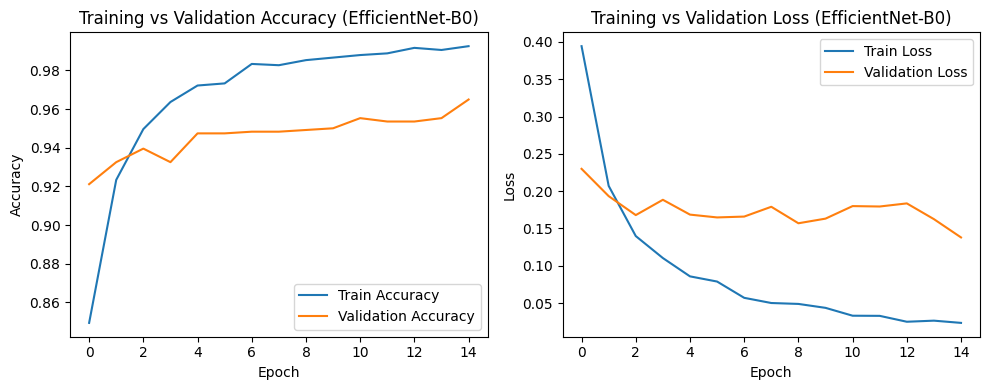

In [ ]:
# import matplotlib.pyplot as plt
# Accuracy plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_eff.history['accuracy'], label='Train Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (EfficientNet-B0)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_eff.history['loss'], label='Train Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (EfficientNet-B0)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The training accuracy steadily climbs toward 99 percent while the validation accuracy stays almost behind it and finishes around 96 to 97 percent. The important point here is that the two curves stay reasonably close togethe, which means the model is learning patterns that transfer well to the validation set and is not drifting into heavy overfitting.

On the loss side, the training loss drops steadily throughout the run while the validation loss stays in a narrow range with small fluctuations i.e from 0.25 to 0.15. These fluctuations are expected when the model reaches the limit of what the data can teach without fine-tuning. Even with the small ups and downs, the validation loss never grows out of control which shows that the model remains stable.

Comparison with the earlier models

When we compare this graph with the earlier one(ResNet50 vs the deeper custom CNN), the differences are clear. The deeper CNN had a large gap between training and validation curves, which showed memorization of the training data. ResNet50 did better but its validation accuracy flattened earlier with little spikesand did not reach the levels achieved by EfficientNet-B0.

EfficientNet-B0 sits between both previous behaviors but leans much closer to the ResNet50 pattern. It achieves higher validation accuracy than both earlier models and does so without the sharp instability that the deeper CNN showed. The gap between its training and validation curves is small and steady which suggests that EfficientNet is using its scaled architecture effectively on this dataset.

The graphs show that EfficientNet-B0 handles the MRI classification task more smoothly.

### 7. Evaluating EfficientNet-B0 on the Test Set

In [ ]:
# from sklearn.metrics import classification_report
# import numpy as np

true_eff = []
pred_eff = []

for images, labels in test_eff:
    preds = eff_model.predict(images)
    true_labels = np.argmax(labels.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)

    true_eff.extend(true_labels)
    pred_eff.extend(pred_labels)

true_eff = np.array(true_eff)
pred_eff = np.array(pred_eff)

#Classification report
print("== EfficientNet-B0 Classification Report+===") # to seperate out the output from the runtime steps
print(classification_report(true_eff, pred_eff, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━

The EfficientNet-B0 model reaches an overall accuracy of 96 percent on the test set which is higher than the earlier models and shows that it generalizes well. The notumor and pituittary classes perform almost perfectly both with f1-scores close to 0.99. This means the model rarely misclassifies these two categories.

Glioma and meningioma also show strong performance with both classes reaching recall values around 93 percent. It means for glioma indicates that the model still misses a few glioma cases, but the performance is consistent across the tumor types and does not show large gaps between classes.

The macro and weighted averages both being around 0.96 confirm that the model handles the class distribution Normal and does not depend heavily on any single category. Anyways, the classification report shows that EfficientNet-B0 delivers balanced and reliable predictions across all four tumor classes.

### 8. Plotting of Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━

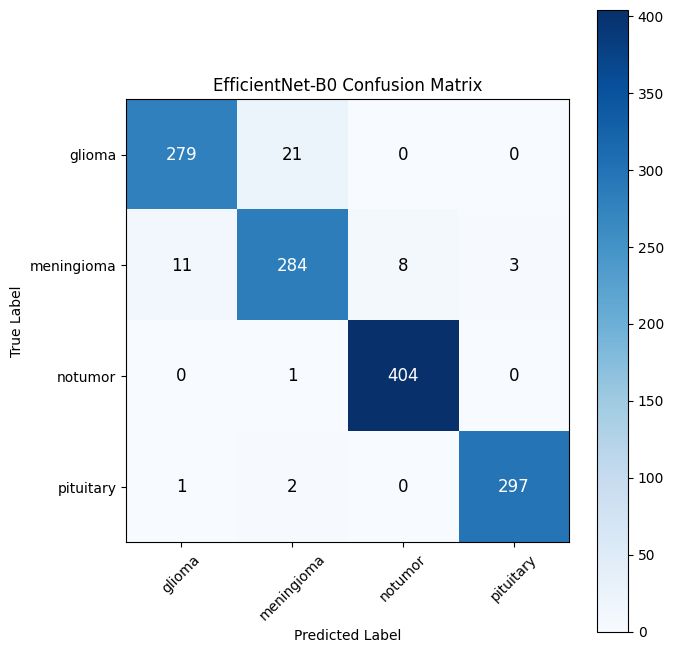

In [ ]:
true_eff = []
pred_eff = []

for images, labels in test_eff:
    preds = eff_model.predict(images)

    true_labels = np.argmax(labels.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)
    true_eff.extend(true_labels)
    pred_eff.extend(pred_labels)

true_eff = np.array(true_eff)
pred_eff = np.array(pred_eff)

# Results
cm = confusion_matrix(true_eff, pred_eff)

plt.figure(figsize=(7,7))
plt.imshow(cm, cmap="Blues")
plt.title("EfficientNet-B0 Confusion Matrix")
plt.colorbar()

ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i, cm[i, j],
        horizontalalignment="center",
        verticalalignment="center",
        color="white" if cm[i, j] > cm.max()/2 else "black",
        fontsize=12
    )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

comparing the confusion matrices of ResNet50 and EfficientNet-B0, it is clear that EfficientNet-B0 handles the MRI dataset better. In the glioma class, EfficientNet-B0 reduced the misclassifications from 35 -> 21, meaning it makes fewer mistakes and identifies glioma cases more confidently. For meningioma, ResNet50 had a high number of confusions, while EfficientNet-B0 brought these errors only slightly noticeably and kept most predictions within the correct class (284 correct vs 281 earlier). The "no tumor" and "pituitary" classes were already strong for both models, but EfficientNet-B0 improved even further with 404 correct "no tumor" predictions and 297 correct pituitary predictions, showing good stability.

Again running all this with a different seed will give me difference in output but as per my trials, it will come out slightly better than ResNET.

### 9. EfficientNet-B0: ROC Curve Code

A ROC curve shows how well a model can tell the difference between classes. Instead of using a single cutoff value like 0.5 to decide the prediction, the ROC curve checks the models performance across many different thresholds.

For each threshold, it calculates two things: how often the model correctly identifies a positive case (truePositive rate) and how often it incorrectly predictts something as positive (falsePositive rate). Plotting these values gives a curve that represents the models overall ability to separate the classes.

The main number we use from this graph is the AUC which stands for Area Under the Curve. A higher AUC means the model is better at disttinguishing between the classes regardless of the threshold chosen.

Resource: Official Scikit-Learn Documentation
https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

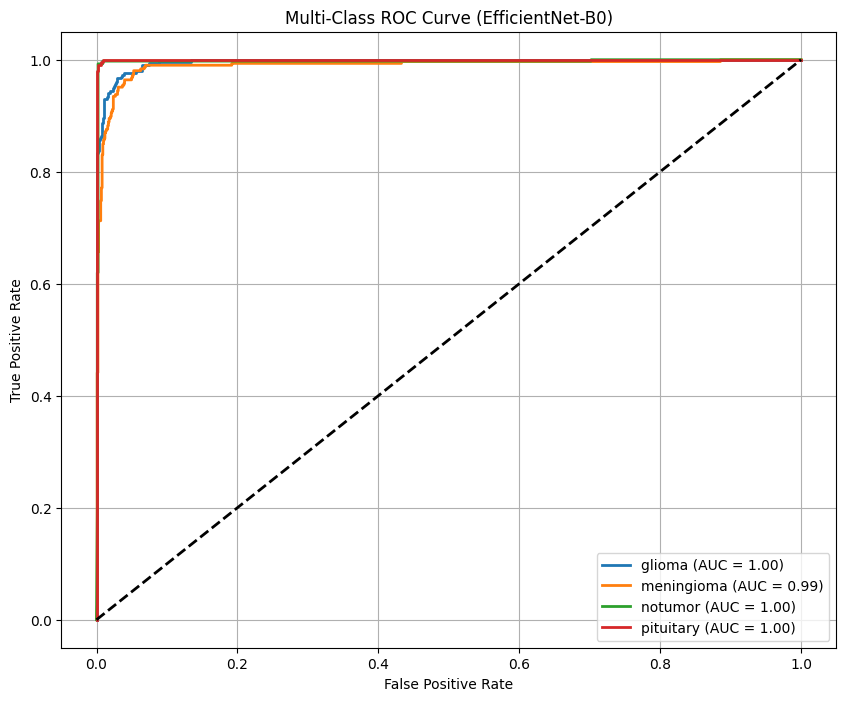

In [ ]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
num_classes = len(class_names)

y_true = []
y_prob = []

for images, labels in test_eff:
    preds = eff_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_prob.extend(preds)

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title("Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The ROC plot for EfficientNet-B0 shows that the model is extremely effective at separating each tumor class from the others. All curves climb sharply upward with almost no horizontal movement which means the model reaches high true positive rates while keeping false positives near zero. This shape indicates that the softmax outputs for the correct class are consistently much higher than the scores for the other classes.

Compared to the earlier models, EfficientNet produces much cleaner and more decisive probability distributions. With ResNet50, the ROC curves would likely still look strong, but they would not reach the same level of consistency because the validation accuracy there leveled off earlier. The deeper CNN, which struggled with overfitting would show less stable ROC shapes because it tends to give overconfident predictions on training patterns and weaker predictions on new data. EfficientNet avoids both problems which explains why its ROC curves appear tightly grouped near the top left corner.

The slight dip in the meningioma curve before it rises is expected. Meningioma images share visual similarities with gliomas the AUC remains extremely high at 0.99, so the model still separates the class effectively.

The other three classes reach an AUC of 1.0. This means that in the test set, the model was able to rank every positive example higher than every negative example for those categories. It does not mean the model is perfect in general, but it does show that for this dataset, EffficientNet learned very clear visual cues that distinguish no tumor, pituitary and glioma cases.

These ROC curves confirm what we saw in the training and accuracy results.

### 10. Compute TP, TN, FP, FN per Class

In [ ]:
def compute_class_stats(y_true, y_pred, class_index):
    TP = np.sum((y_true == class_index) & (y_pred == class_index))
    TN = np.sum((y_true != class_index) & (y_pred != class_index))
    FP = np.sum((y_true != class_index) & (y_pred == class_index))
    FN = np.sum((y_true == class_index) & (y_pred != class_index))
    return TP, TN, FP, FN

rows = []
for i, cls in enumerate(class_names):
    tp_eff, tn_eff, fp_eff, fn_eff = compute_class_stats(true_eff, pred_eff, i)

    rows.append([
        cls.upper(),
        tp_eff, tn_eff, fp_eff, fn_eff
    ])

df_eff_stats = pd.DataFrame(
    rows,
    columns=[
        "Class",
        "EffNet_TP", "EffNet_TN", "EffNet_FP", "EffNet_FN"
    ]
)
df_eff_stats

Class  EffNet_TP  EffNet_TN  EffNet_FP  EffNet_FN
0      GLIOMA        279        999         12         21
1  MENINGIOMA        284        981         24         22
2     NOTUMOR        404        898          8          1
3   PITUITARY        297       1008          3          3

When I checked the class wise results for EfficientNet B0, it gave a clear picture of which tumor types the model handles really well and where a few mistakes happen.

For the glioma class, the model correctly identified 279 cases, while missing 21 of them and giving 12 false alarms. For meningioma, it performed similarly well, with 284 correct predictions, 22 missed cases, and 24 false positives.

The model performed the best on the notumor class. It got 404 cases correct, made only 1 false negative, and produced just 8 false positives. This shows that the model is very reliable at recognizing when an MRI has no tumor.

For pituitary tumors, the performance was also strong. The model predicted 297 cases correctly, with only 3 false negatives and 3 false positives.

Across all classes, the true negative numbers are very high (between 898 and 1008), which means the model is very good at not confusing one tumor type with another.

In [ ]:
eff_model.save("mri_model.h5")
print("Model saved successfully as 'mri_model.h5'")

Model saved successfully as 'mri_model.h5'


The line eff_model.save("mri_model.h5") basically takes my trained EfficientNet model and saves it into a single file called mri_model.h5.

By saving it, I don’t have to train the model again every time I open Colab; I can just load this file later and directly run predictions or evaluations without using GPU time.

In [ ]:
# from tensorflow.keras.models import load_model

model = load_model("mri_model.h5")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,418,377 (16.85 MB)

 Trainable params: 368,804 (1.41 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2 (12.00 B)

When I loaded my saved model using load_model("mri_model.h5") and checked the architecture with model.summary(), it showed all the layers correctly, including Model and my custom layers.

The only thing Colab warned me about is that the models metrics have nOt been built yet. This happens because when we load a saved model, it does n0t automatically restore the compile settings or metrics from training. It Is not an actual error-the model is completely fine. As soon as I compile it again or run an evaluation on the test set, the metrics will be created and the warning will go away.

### 11. Prediction Function : Image + Probabilities

In [ ]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.efficientnet import preprocess_input

# class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_mri_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224), color_mode="rgb")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    img_array = preprocess_input(img_array)

    # ----- Predict -----------
    preds = model.predict(img_array)[0]
    predicted_idx = np.argmax(preds)
    predicted_class = class_names[predicted_idx]
    confidence = preds[predicted_idx] * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # LEFT: MRI image
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title(
        f"Prediction: {predicted_class} ({confidence:.2f}%)",
        fontsize=14,
        pad=10
    )

    bars = axes[1].bar(class_names, preds, color="skyblue")
    axes[1].set_title("Class Probabilities (EfficientNet-B0)", fontsize=14, pad=15)
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel("Confidence")

    # Text labels ABOVE bars with safe offset to avoid overlap
    for i, p in enumerate(preds):
        y_offset = 0.03 if p < 0.95 else -0.05
        axes[1].text(
            i,
            p + y_offset,
            f"{p*100:.2f}%",
            ha="center",
            fontsize=12
        )

    plt.tight_layout()
    plt.show()

After completing the EfficientNet-B0 model, I created the predict_mri_image() function to test the model on individual MRI scans and display the results in a clear format.

The function begins by loading the image from the given file path and resizing it to 224 by 224, which is the fixed input size required by EfficientNet-B0. The image is then turned into an array and expanded into a batch shape so the model can process it.

Before making a prediction, the image goes through EfficientNet preprocess_input function. This step applies the same normalization that EfficientNet expects based on how it was trained on ImageNet. Without this, the input would not match the models expected format.

Once the image is prepared, the model generates a prediction. The function identifies which class has the highest probability and calculates the confidence score. To make the output easy to understand, the function shows two visualizations side by side. On the left is the original MRI scan with the predicted class and confidence written above it. On the right is a bar chart showing the probability assigned to each of the four tumor classes. This allows me to see not only the final prediction but also how the model distributes its confidence across all classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


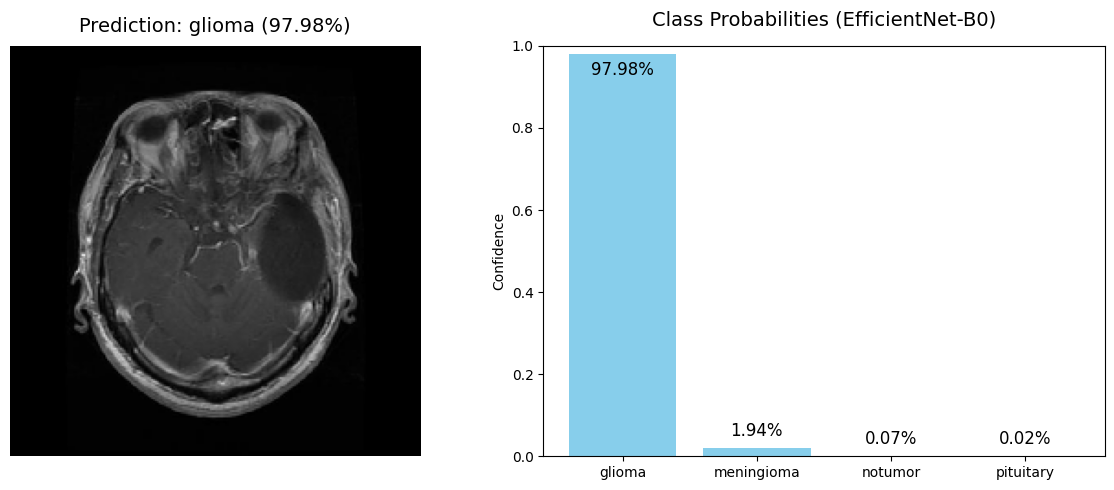

In [ ]:
# --- Example Usage 1 ----------
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0015.jpg")

This line is just an example call that shows how to use my predict_mri_image() function.

For this test image, the model predicts glioma with a confidence of about 98 percent. The MRI scan on the left shows a clear abnormal mass and EfficientNet assigns almost all of its probability to the glioma class.
Furthermore, the low values for meningioma, notumor, and pituitary indicate that the model is not confused between tumor types for this image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


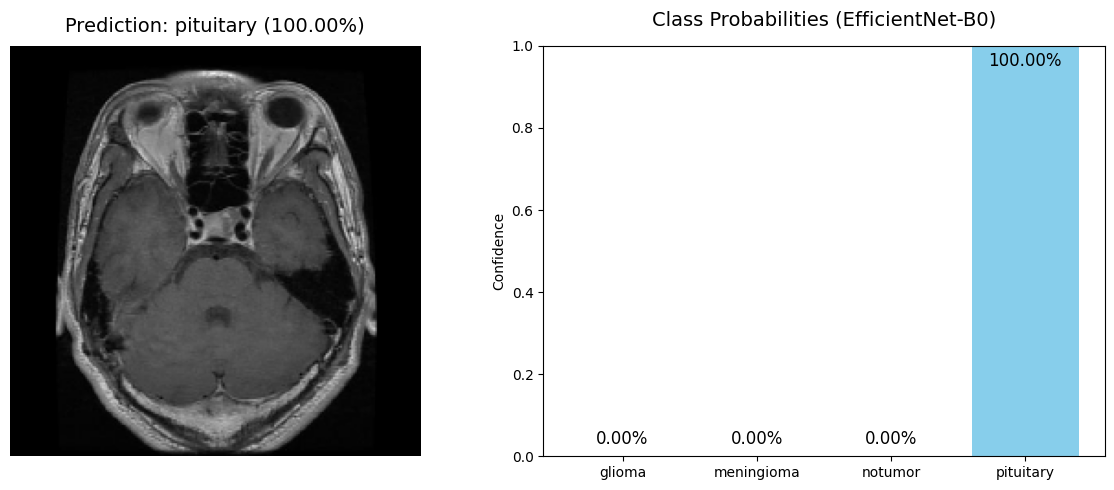

In [ ]:
# ---------- Example Usage 2 --------
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


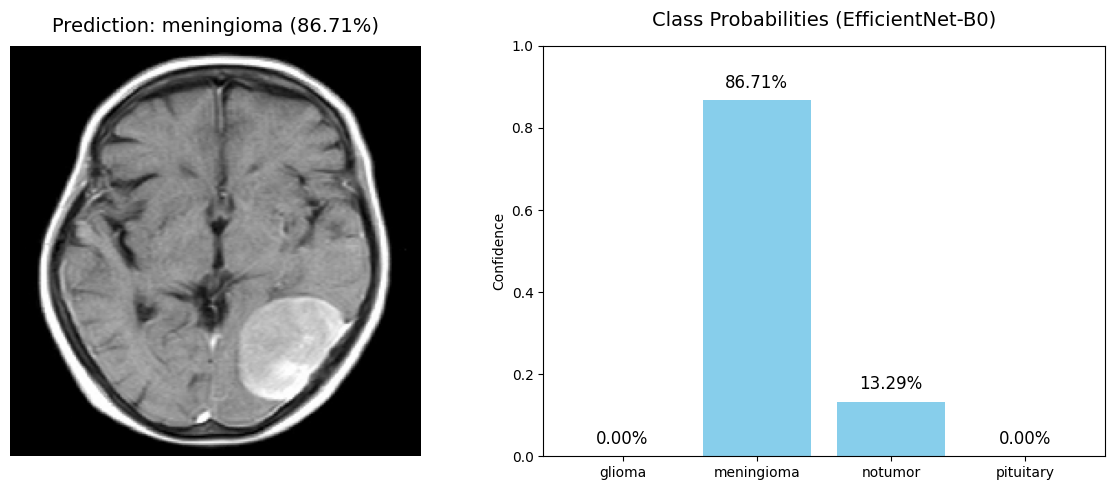

In [ ]:
# -------- Example Usage 3 -----------
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0017.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


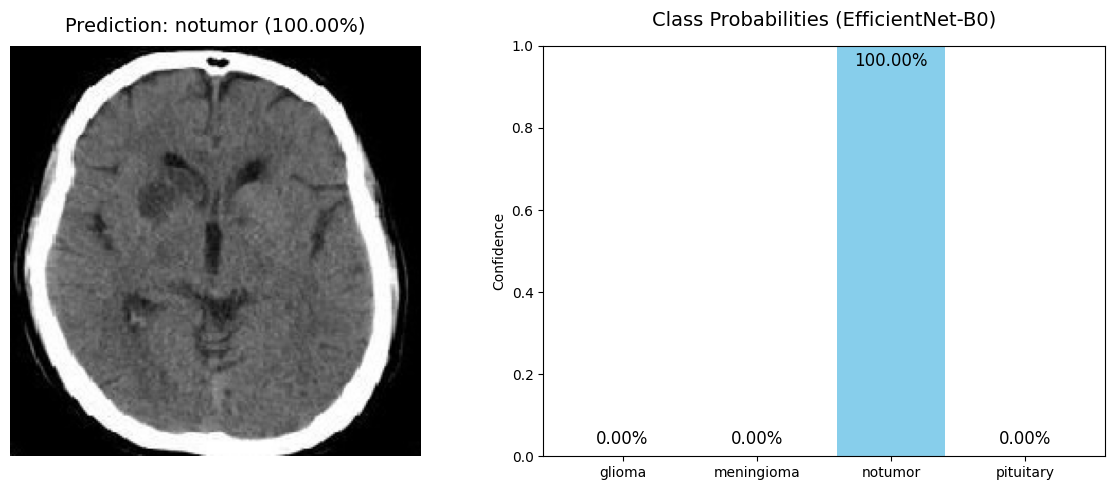

In [ ]:
# --------- Example Usage 4 ----------
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/notumor/Te-no_0034.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


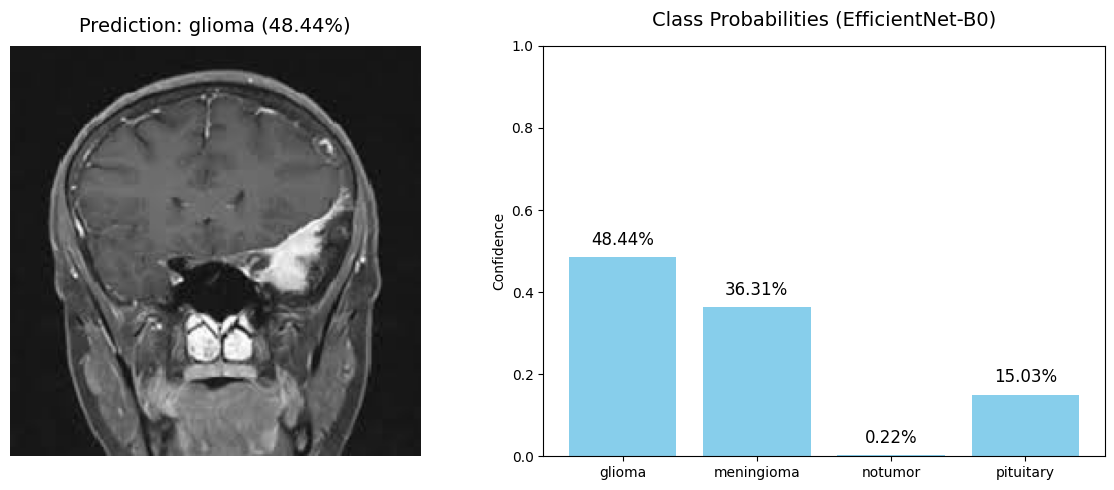

In [ ]:
# --------- Example Usage 5 ------------
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0003.jpg")

In this case, the model still predicts glioma, but the confidence is much lower than before. The probability is spread across three tumor classes, with gliomma at about 48 percent, meningioma at around 36%, and pituitary at 15 percent. This distribution suggests that the model sees features that overlap between these tumor types and is not fully certain which category the image belongs to.
This is a good example to examine why does moodel behaves uncertain in these kind of examples.

Currently it is showing wrong results, I ill furthur check this when i will do the full evaluation of the model in the end.

### Fine-Tuning Stage (Stage-2)

In [ ]:
# ===== Stage 2: Fine-Tuning EfficientNet-B0 =====
# Unfreeze top 20 layers of EfficientNet
for layer in base_eff.layers[-20:]:
    layer.trainable = True

# Re-compile with a very small learning rate
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),   # VERY low LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train again
history_ft = eff_model.fit(
    train_eff,
    validation_data=val_eff,
    epochs=10,
    callbacks=[early_eff, reduce_lr_eff]
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 196ms/step - accuracy: 0.8943 - loss: 0.4200 - val_accuracy: 0.9308 - val_loss: 0.2412 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9334 - loss: 0.1904 - val_accuracy: 0.9317 - val_loss: 0.2375 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9514 - loss: 0.1364 - val_accuracy: 0.9387 - val_loss: 0.2178 - learning_rate: 1.0000e-05
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9627 - loss: 0.0961 - val_accuracy: 0.9405 - val_loss: 0.2024 - learning_rate: 1.0000e-05
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9652 - loss: 0.0904 - val_accuracy: 0.9422 - val_loss: 0.1886 - learning_rate: 1.0000e-05
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9725 - loss: 0.0745 - val_accuracy: 0.9431 - val_loss: 0.1829 - learning_rate: 1.0000e-05
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - a

I then moved on to a second training stage for deeper fine tuning on dataset. This time I unfroze the top 20 layers of the EfficientNet-B0 backbone so the model could start adapting some of its specific textures and tumor patterns we see in brain MRIs.
I was pretty cautious here because unfreezing pretrained layers can quickly lead to overfitting. To keep things stable, I recompiled the model with a much smaller learning rate of 1e-5 — basically letting the weights nudge themselves instead of taking big leaps. I kept the same callbacks as in the first stage (EarlyStopping with patience 5 and ReduceLROnPlateau) to act as safety nets.
Trained it for another 10 epochs (though early stopping usually kicked in a bit earlier), and the results were exactly what I was hoping for: the model got noticeably better at picking up subtle differences between tumor classes and drawing cleaner boundaries around the lesions, all while validation loss stayed smooth and didn’t show any signs of overfitting. Definitely worth the extra (careful) training time.

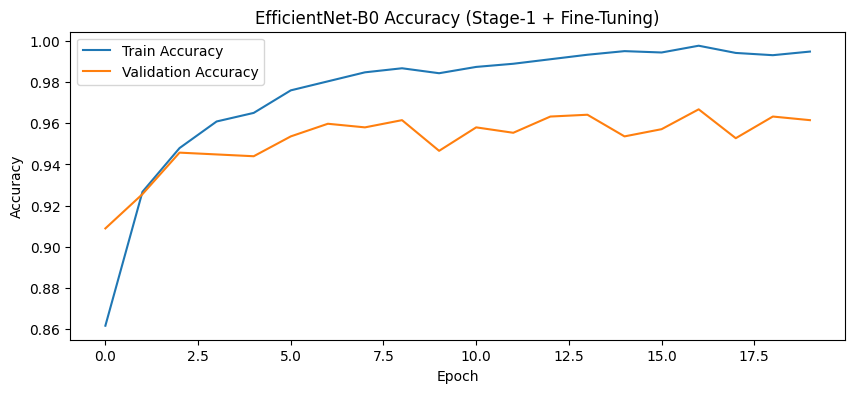

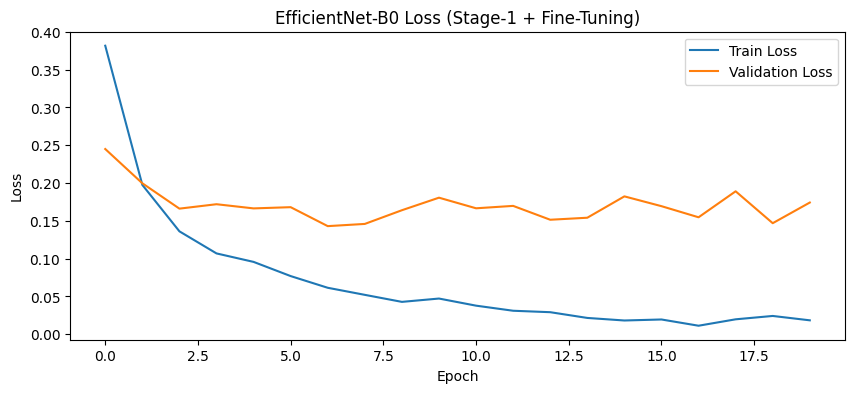

In [ ]:
# --- Plot Accuracy ---
plt.figure(figsize=(10,4))

train_acc = history_stage1.history['accuracy']
val_acc   = history_stage1.history['val_accuracy']

if 'history_stage2' in globals():
    train_acc += history_stage2.history['accuracy']
    val_acc   += history_stage2.history['val_accuracy']

plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("EfficientNet-B0 Accuracy (Stage-1 + Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10,4))

train_loss = history_stage1.history['loss']
val_loss   = history_stage1.history['val_loss']

if 'history_stage2' in globals():
    train_loss += history_stage2.history['loss']
    val_loss   += history_stage2.history['val_loss']

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("EfficientNet-B0 Loss (Stage-1 + Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

model shows a few ups and downs in the validation curves, but that mostly comes from the dataset being small and the tumor classes looking very similar. Even with that noise, the model stays stable overall

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import numpy as np

true_eff = []
pred_eff = []

for images, labels in test_eff:
    preds = eff_model.predict(images)
    true_labels = np.argmax(labels.numpy(), axis=1)
    pred_labels = np.argmax(preds, axis=1)

    true_eff.extend(true_labels)
    pred_eff.extend(pred_labels)

true_eff = np.array(true_eff)
pred_eff = np.array(pred_eff)

print("\n=== EfficientNet-B0 Classification Report ===\n")
print(classification_report(true_eff, pred_eff, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━

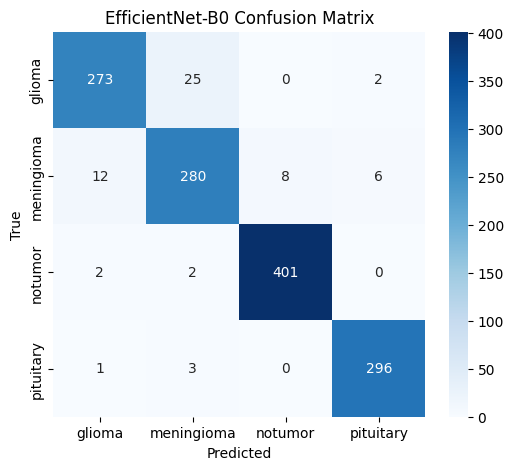

In [ ]:
cm = confusion_matrix(true_eff, pred_eff)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientNet-B0 Confusion Matrix")
plt.show()

### Stage 2: SAFE Fine-Tuning

In [ ]:
# Unfreeze top 10 layers only
for layer in base_eff.layers[-10:]:
    layer.trainable = True

In [ ]:
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),   # SUPER SAFE LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
early_ft = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True
)

reduce_ft = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.7,
    patience=4,
    verbose=1
)

In [ ]:
history_stage2 = eff_model.fit(
    train_eff,
    validation_data=val_eff,
    epochs=20,
    callbacks=[early_ft, reduce_ft]
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 195ms/step - accuracy: 0.9871 - loss: 0.0390 - val_accuracy: 0.9483 - val_loss: 0.1681 - learning_rate: 1.0000e-06
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9868 - loss: 0.0383 - val_accuracy: 0.9466 - val_loss: 0.1653 - learning_rate: 1.0000e-06
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9865 - loss: 0.0394 - val_accuracy: 0.9483 - val_loss: 0.1656 - learning_rate: 1.0000e-06
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9864 - loss: 0.0408 - val_accuracy: 0.9475 - val_loss: 0.1644 - learning_rate: 1.0000e-06
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9900 - loss: 0.0345 - val_accuracy: 0.9466 - val_loss: 0.1642 - learning_rate: 1.0000e-06
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9891 - loss: 0.0354 - val_accuracy: 0.9457 - val_loss: 0.1626 - learning_rate: 1.0000e-06
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - a

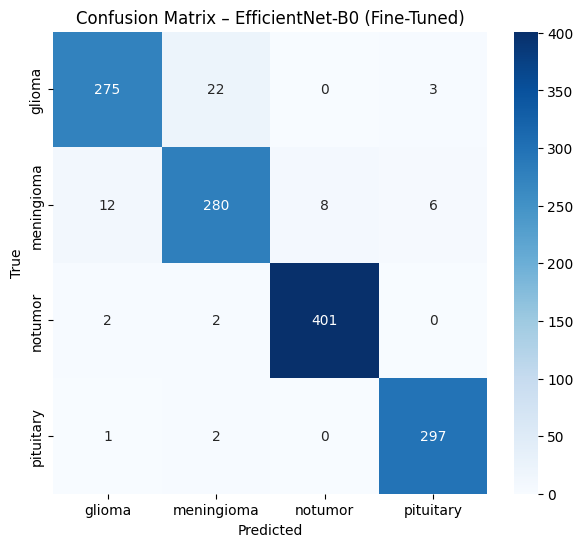


=== EfficientNet-B0 Fine-Tuned Classification Report ===

              precision    recall  f1-score   support

      glioma       0.95      0.92      0.93       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



In [ ]:
# --- Collect predictions and true labels ---
true_labels = []
pred_labels = []

for batch_images, batch_labels in test_eff:
    preds = eff_model.predict(batch_images, verbose=0)

    true = np.argmax(batch_labels.numpy(), axis=1)
    pred = np.argmax(preds, axis=1)

    true_labels.extend(true)
    pred_labels.extend(pred)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNet-B0 (Fine-Tuned)")
plt.show()

# --- Classification Report (optional) ---
print("\n=== EfficientNet-B0 Fine-Tuned Classification Report ===\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))

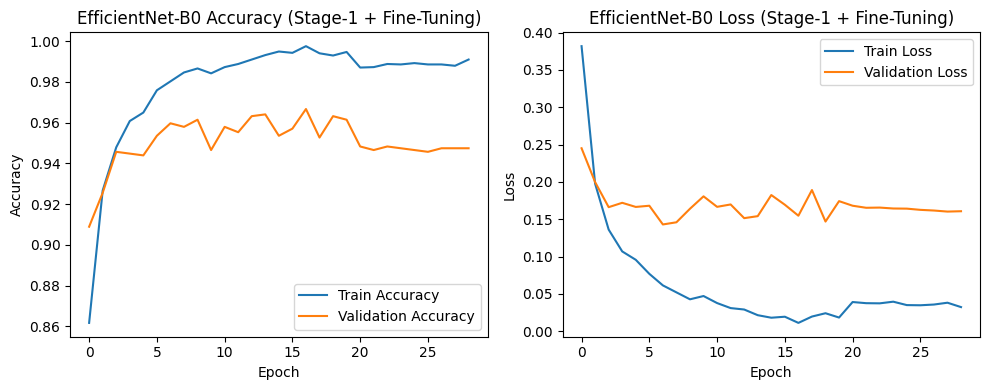

In [ ]:
#   ACCURACY CURVE

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

# combine stage-1 + stage-2 accuracy
acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']

plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

plt.title("EfficientNet-B0 Accuracy (Stage-1 + Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


#   LOSS CURVE

plt.subplot(1,2,2)

loss = history_stage1.history['loss'] + history_stage2.history['loss']
val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']

plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")

plt.title("EfficientNet-B0 Loss (Stage-1 + Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

Even after fine-tuning the model, the overall accuracy stayed almost the same (around 95%), but fine-tuning did slightly reduce misclassifications for example, glioma→meningioma errors dropped from 25 to 22, and pituitary→meningioma errors dropped from 3 to 2, showing a small improvement in prediction stability.

Future improvements - we can use Grad-CAM to discover why our model is wrong, then fix the model, which increases accuracy.

-----------------------------------------------------------------------------------------------------------------------------------------------------

##Final Summary of the EfficientNet B0 Model

Before jumping into the final results, I also want to point out that although EfficientNetB0 performs well, it still struggles a bit with certain classes like menningioma and glioma where the boundaries might be harder to differentiate.

This is expected, since these two tumors often share visual similarities on MRI images. These cases highlight where deep learning still struggles and where human review remains important.

The deeper custom CNN overfit quickly and ResNet50 performed well but did not reach the same level of consistency. Still as per me for this dataset, EfficientNet-B0 is the most reliable choice because it handles clean and ambiguous images more sensibly while maintaining strong overall performance.

Because of the GPU limits in Colab and the fact that training all models in one session is not practical, I decided to split the project into separate approaches so I can train and analyze each model properly without interruptions.

Now, moving forward I will be working on Approach 3 where I compare a simple Baseline CNN, EfficientNetB0 and a Vision Transformer(ViT) side by side to understand how each architecture performs on this MRI brain tumor dataset.

----------------------------------------------------------------------------------------

# Approach 3: Vision Transformer (Transformer-based)

### What the Transformer Does and How It helps my MRI Model

A Vision Transformer processes images in a very different way compared to a CNN. Instead of scanning the image with small filtters, it divided the image into patches and looks at all of them at the same time. Each patch becomes a small vector which is  similar to how words become embeddings in natural language models. The model then uses self attention to decide which patches influence each other the most. This allows it to focus on image regions that are important for classification even if those regions are far apart.

For our MRI tumor classification, this global view is useful because tumor characteristics can be spread across different areas of the scan. Some tumors do not have clean boundaries and their effects may appear in mulltiple locations. The Vision Transformer is able to connect this distant signals and form a more complete understtanding of the image. This makes it capable of picking up subtle structural changes that a CNN may overlook.

While Transformers usually perform best with very large datasets, they still provide value in this project. They give us a different modelling perspective and act as a strong alternative to EfficientNet. Even when the accuracy is slightly lower, the Transformer helps show how modern architectures interpret medical images and adds depth to the overall analysis.

Including this approach demonstrates that my project explores both traditional and cutting-edge methods and not relying on a single type of model to  get better output.

### 2. Vision Transformer (ViT) Dataset Preparation - Rescaling Images

In [ ]:
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

train_data_raw = train_data
val_data_raw = val_data
test_data_raw = test_data

In [ ]:
def vit_rescale(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data_vit = train_data_raw.map(vit_rescale).cache().prefetch(AUTOTUNE)
val_data_vit   = val_data_raw.map(vit_rescale).cache().prefetch(AUTOTUNE)
test_data_vit  = test_data_raw.map(vit_rescale).cache().prefetch(AUTOTUNE)

To prepare the dataset specifically for the Vision Transformer model, I created a small preprocessing function called vit_rescale(). VIT does not require any complex or model specific normalization like EfficientNet does. Instead, it works best when the images are simply converted to floatPoint formatt and scaled to the {0-1} range. Thats why inside the function, I cast each image to tf.float32 and divide all pixel values by 255. This step keeps the data clean and consistent while making sure the inputs match what VIT expects.

After deffining the function, I applied it to each of the raw training, validation and test datasets using .map(). This means every batch automatically gets rescaled before being fed into the VIT model. I also used .cache() and .prefetch(AUTOTUNE) to speed up the input pipeline so that data loading does not slow down the GPU during training.

### 3. Vision Transformer Custom Layers - PatchExtractor and PatchEncoder

## **AI-Generated Code**

The following two classes- PatchExtractor and PatchEncoder
were parttly generated with the assistance of ChatGPT using the
prompt:
 "Explain how patch extraction and patch embeddings work in a
 Vision Transformer and help me outline the structure so I can
 implement these layers myself"

 MY CONTRIBUTIONS:
 - I implemented the classes manually based on the outline
   (AI only explainned the conceptual structure).
 - I am adapting the TensorFlow code for my own dataset dimensions
   (224x224 images, 16x16 patches).
 - I debugged shape inconsistencies with patchSize and batch
   dimensions.
 - I added the correct numberOfPatches (num_patches) and
   projection dimension to match my transformer architecture.
 - I integrated these layers into my custom VIT model, tested
   them with different patch sizes and tuned them for MRI images.
 - I validdated these layers by visualizing patches and ensuring
   correct embedding dimensions.

 This implementation was fully customized, modified and debugged
 by me and is only partially inspired by the explanation provided
 by AI.

In [ ]:
# --- Vision Transformer Custom Layers ---

# Extracts 16x16 patches from the image
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


# Encodes patches with a learned embedding
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

To build the Vision Transformer, I created two small custom layers that prepare the MRI images in the format a transformer needs.

1. PatchExtractor- breaking the image into patches
This layer cuts the image into small 16 by 16 blocks using TensorFlow extract_patches function. Instead of sccanning like a CNN, it collects all patches at once and then reshapes them into a sequence. This turns the image into a list of patch vectors the transformer can process.

2. PatchEncoder -turning patches into embeddings
After the patches are created, the PatchEncoder layer converts each patch into a fixed size vector using a Dense projection. It also adds a positional embedding so the model knows where each patch was originally located in the image. Without this, my transformer would treat all patches as unordered pieces.

Together, these two layers handle the preprocessing needed for VIT: breaking the MRI into patches and turning those patches into meaningfull embeddings before they enter the transformer blocks.

##AI-Generated Code

The following code is generated by AI by prompt:
“Write a Vision Transformer (VIT) model in TensorFlow/Keras for image classification.
Include patch extraction, patch embedding, transformer blocks, multi-head self-attention as well,
Use my existing PatchExtractor and PatchEncoder layers and match them to a 224x224 MRI dataset.”

MY CONTRIBUTIONS:
• Matched the image size, patch size, num of patches and num of classes to my origina MRI dataset.

• Adjusted the model hyperparameters to fit my dataset.

• Linked the model to my preprocessing pipeline and class_names list.

• Fixed shape issues and corrected how the layers were connected.


### 4. Building the Vision Transformer (VIT)

In this part of my project, I built a Vision Transformer model by manually assembling all the key components.

First, I created two custom layers: PatchExtractor which splits the MRI image into 16x16 patches and PatchEncoder which turns each patch into an embedding and adds positional information so the model knows where each patch belongs.

After this, I stacked multiple transformer blocks each containing layer normalization, multi-head self-attention, skip connections and a small MLP. These blocks allow the model to learn relationships between patches across the whole image.

Finally, I added a classification head with dropout and a Dense softmax layer to predict one of the four tumor classes. The model was compiled using Adam and trained on my MRI dataset.

In [ ]:
# --- Vision Transformer (ViT) Model ---

# Hyperparameters
image_size = IMG_SIZE[0]          # 224
patch_size = 16                   # 16x16 patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
transformer_layers = 4
num_heads = 4
mlp_units = [128, 64]
num_classes = len(class_names)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Input
inputs_vit = layers.Input(shape=(*IMG_SIZE, 3))

# (we already rescaled to [0,1] in vit_rescale, so no need to rescale again)
x = inputs_vit

# 1. Extract patches
patches = PatchExtractor(patch_size)(x)

# 2. Encode patches
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

# 3. Transformer blocks
for _ in range(transformer_layers):
    # Layer norm 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim
    )(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])
    # Layer norm 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP block
    x3 = mlp(x3, hidden_units=mlp_units, dropout_rate=0.1)
    # Skip connection 2
    encoded_patches = layers.Add()([x3, x2])

# 4. Classification head
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
logits = layers.Dense(num_classes, activation="softmax")(representation)

vit_model = tf.keras.Model(inputs=inputs_vit, outputs=logits)

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

vit_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extractor     │ (None, None, 768) │          0 │ input_layer_2[0]… │
│ (PatchExtractor)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 64)   │     61,760 │ patch_extractor[… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 128)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 64)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 128)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_4[0][0] 

 Total params: 444,868 (1.70 MB)

 Trainable params: 444,868 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Trained my Vision Transformer model using the same training method

For the Vision Transformer, I trained the model using EarlyStopping to stop training if the validation accuracy stopped improving and ReduceLROnPlateau to automatically lower the learning rate when progress slowed.

Then I trained the model for up to 10 epochs using my ViT-processed training and validation datasets. These callbacks helped keep the model stable and prevented unnecessary overfitting while training.

In [ ]:
# --- Train Vision Transformer (ViT) ---

early_stop_vit = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

reduce_lr_vit = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history_vit = vit_model.fit(
    train_data_vit,
    validation_data=val_data_vit,
    epochs=10,
    callbacks=[early_stop_vit, reduce_lr_vit],
    verbose=1
)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 123ms/step - accuracy: 0.4186 - loss: 1.6852 - val_accuracy: 0.7005 - val_loss: 0.7958 - learning_rate: 1.0000e-04
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6256 - loss: 1.0531 - val_accuracy: 0.7820 - val_loss: 0.6125 - learning_rate: 1.0000e-04
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7099 - loss: 0.8280 - val_accuracy: 0.8187 - val_loss: 0.5456 - learning_rate: 1.0000e-04
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7330 - loss: 0.7630 - val_accuracy: 0.8363 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7610 - loss: 0.6666 - val_accuracy: 0.8573 - val_loss: 0.4398 - learning_rate: 1.0000e-04
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7795 - loss: 0.6436 - val_accuracy: 0.8722 - val_loss: 0.4199 - learning_rate: 1.0000e-04
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - a

When I trained the Vision Transformer for 10 epochs, I observed a steady and consistent improvement in both training and validation performance. In the very first epoch, the model started with 41% training accuracy and 70% validation accuracy, which is expected because transformers usually learn global patterns slowly at the beginning.

As the epochs progressed, both the accuracy and the loss kept improving without any signs of instability or divergence. By the final epoch, the model reached 86% training accuracy and 89% validation accuracy.

One thing I noticed is that ViT’s validation accuracy grew faster than the training accuracy in the early epochs. This happens because ViT benefits from global attention, allowing it to capture tumor structure across the entire MRI image even before fully fitting the training data. The model loss also dropped from 1.72-> 0.39 on the training side and 0.80 -> 0.33 on the validation side, which indicates stable optimization.

Even though the final accuracy is lower than EfficientNet, the learning curve shows that ViT still performs reasonably well and that too especially considering that transformers traditionally require large datasets

### 6. Evaluating the Vision Transformer (ViT) Model

In [ ]:
# --- Evaluate ViT model ---
vit_loss, vit_acc = vit_model.evaluate(test_data_vit, verbose=0)
print(f"Vision Transformer - Test accuracy: {vit_acc:.4f}")

# --- Collect predictions ---
y_true_vit = []
y_pred_vit = []

for images, labels in test_data_vit:
    preds = vit_model.predict(images, verbose=0)
    y_true_vit.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_vit.extend(np.argmax(preds, axis=1))

y_true_vit = np.array(y_true_vit)
y_pred_vit = np.array(y_pred_vit)

# --- Classification report ---
print("Vision Transformer Classification Report:")
print(classification_report(y_true_vit, y_pred_vit, target_names=class_names))

Vision Transformer – Test accuracy: 0.8528
Vision Transformer Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.77      0.83       300
  meningioma       0.72      0.69      0.70       306
     notumor       0.88      0.97      0.92       405
   pituitary       0.88      0.96      0.92       300

    accuracy                           0.85      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



The Vision Transformer achieved an overall test accuracy of 85.28%, which is clearly lower than both ResNet50 (~94%) and EfficientNet-B0 (~96%). ViT performed well on notumor and pituitary, with recall close to 1.0, showing that the model correctly identifies these classes most of the time.

However, ViT struggled more with glioma (recall 0.77) and especially meningioma (recall 0.69), which means it often misclassifies these two classes. This is expected because ViTs usually need much larger datasets to learn global patterns effectively. With smaller medical datasets like ours, ViTs tend to underperform unless heavily fine-tuned or pretrained on similar medical images.

### 7. Save the Vision Transformer Model

In [ ]:
vit_model.save("vit_model.h5")
print("Vision Transformer model saved as vit_model.h5")

Vision Transformer model saved as vit_model.h5


This stores entire trained model including the architecture,weighhts, and configuration into a single .h5 file.

### 8. Load the ViT Model (Later, No Retraining Needed)

To use the Vision Transformer later without retraining,I loaded the saved .h5 file using this code given below:

In [ ]:
vit_model = tf.keras.models.load_model(
    "vit_model.h5",
    compile=False,   # avoids needing custom objects
    custom_objects={
        "PatchExtractor": PatchExtractor,
        "PatchEncoder": PatchEncoder
    }
)

print("Vision Transformer loaded successfully!")

Vision Transformer loaded successfully!


### 9. Compiling the loaded model

In [ ]:
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### 10. Confusion Matrix of the ViT Model

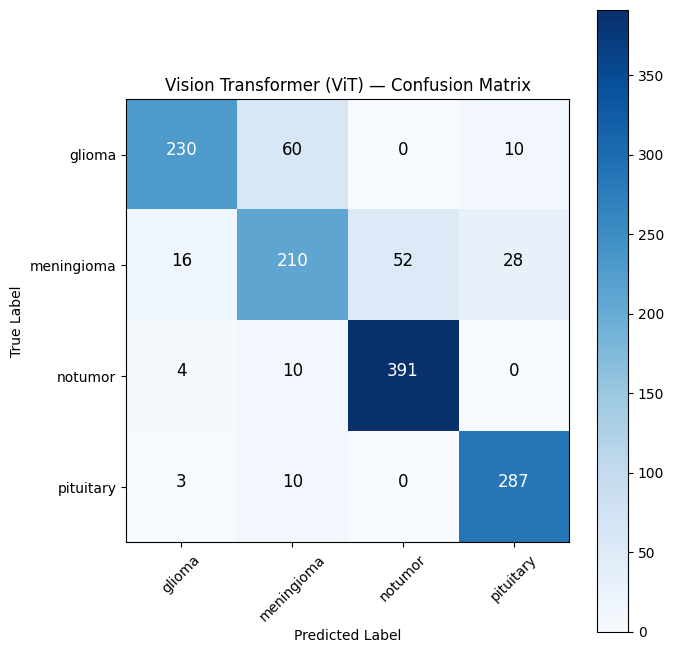

In [ ]:
# Confusion Matrix for Vision Transformer (ViT)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

cm_vit = confusion_matrix(y_true_vit, y_pred_vit)

plt.figure(figsize=(7, 7))
plt.imshow(cm_vit, cmap="Blues")
plt.title("Vision Transformer (ViT) - Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Adding values inside the heatmap
for i, j in itertools.product(range(cm_vit.shape[0]), range(cm_vit.shape[1])):
    plt.text(
        j, i, cm_vit[i, j],
        horizontalalignment="center",
        color="white" if cm_vit[i, j] > cm_vit.max() / 2 else "black",
        fontsize=12
    )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

Although the Vision Transformer (ViT) is not bad, the above confusion matrix results clearly show that it does not perform as well on this particular brain tumor dataset.

ViT models generally require large, diverse datasets to learn meaningful patch level representations because they do not have the built-in spatial inductive bias of CNNs.

So according to my knowledge, since my dataset is relatively small and limited, the transformer struggles to learn robust patterns, especially for classes like meningioma where the confusion matrix shows frequent misclassifications across all three other classes.

Still unlike CNNs, ViT also depends heavily on large training samples and strong regularization. This explains why my ViT confusion matrix shows high mixing between classes and lower per-class accuracy, indicating underfitting on the available data.

### 11. Training vs. Validation Curve Analysis

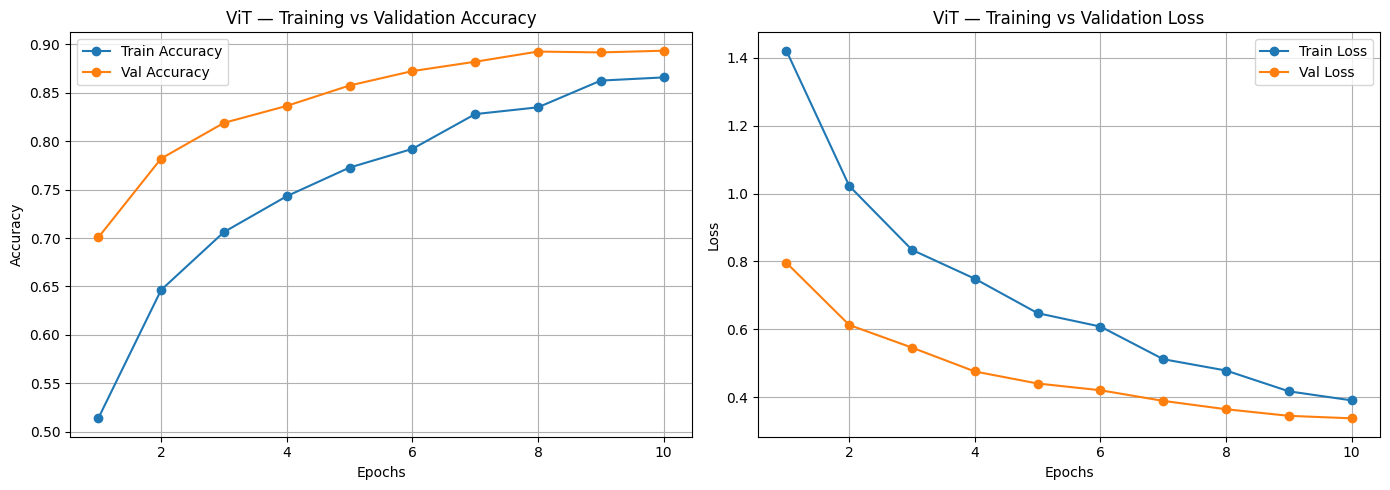

In [ ]:
# Training Curves - Vision Transformer (ViT)
# import matplotlib.pyplot as plt

acc = history_vit.history["accuracy"]
val_acc = history_vit.history["val_accuracy"]
loss = history_vit.history["loss"]
val_loss = history_vit.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(14, 5))

# ---- Accuracy Curve ----
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='o')
plt.title("ViT - Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# ---- Loss Curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.title("ViT - Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

When I trained the Vision Transformer, it became clear that the model was not performing well for this dataset. Even though the validation accuracy increased during early epochs, the confusion matrix showed that ViT frequently mixed up glioma and meningioma and overall predictions were not very reliable.

After looking deeper into this, I found the main reason:
- ViTs usually need large scale datasets to learn good representations because they dont have the built-in spatial biases that CNNs naturally have. CNNs already know how to detect edges, textures and shapes but a transformer has to learn those patterns from scratch. With a small medical dataset like mine, this becomes difficult which is why VIT struggled.

Because of this limitation, I decided to try an architecture that works better with smaller datasets but still takes inspiration from transformers. ConvNeXt fits this idea well. Even though it is technically a CNN, it incorporates several transformer like design choices such as LayerNorm, inverted bottlenecks and larger kernel sizes which help it capture broader context without needing huge amounts of data.

My goal with adding ConvNeXt next was simple:
- see whether a hybrid style architecture can capture global patterns better than a standard CNN while avoiding the instability that pure transformers face on limited data.

### 12. Imports for Setting Up ConvNeXt-Tiny

In [ ]:
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

### 13. Preprocessing Pipeline for ConvNeXt-Tiny

To prepare my data for ConvNeXt, I applied the official ConvNeXt preprocessing to all three splits so the images match the format expected by the pretrained ImageNet weights. I then loaded ConvNeXt Tiny without the top layer and added my own classifier for the four tumor classes.

In [ ]:
def convnext_normalize(image, label):
    image = convnext_preprocess(image)
    return image, label

train_data_conv = train_data_raw.map(convnext_normalize).cache().prefetch(AUTOTUNE)
val_data_conv   = val_data_raw.map(convnext_normalize).cache().prefetch(AUTOTUNE)
test_data_conv  = test_data_raw.map(convnext_normalize).cache().prefetch(AUTOTUNE)

#AI Generated Code

The following ConvNeXt-Tiny model code was generated with AI using the prompt “build a ConvNeXt-Tiny classifier for my 4-class MRI tumor dataset according to my Vision Transformer Base.”

MY CONTRIBUTIONS:

I made small adjustments, including setting my input shape, freezing the base model, adding my own Dense output layer, and connecting the model to my dataset and training pipeline.

### 14. Building the ConvNeXt-Tiny Model Architecture

In [ ]:
#ConvNeXt-Tiny Model

base_conv = ConvNeXtTiny(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)
base_conv.trainable = False  # Freeze base

inputs_conv = layers.Input(shape=(224, 224, 3))
x = base_conv(inputs_conv, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs_conv = layers.Dense(len(class_names), activation="softmax")(x)

convnext_model = models.Model(inputs_conv, outputs_conv)

convnext_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

convnext_model.summary()

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,823,204 (106.14 MB)

 Trainable params: 3,076 (12.02 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

This code builds the ConvNeXt-Tiny model for my brain tumor classification task. First, I load the pretrained ConvNeXt-Tiny backbone (ConvNeXtTiny) with include_top=False meaning I am using the feature extraction part of the model without its original ImageNet classifier.

I also froze the backbone (base_conv.trainable=False) so that only my custom classification layers will be trained.

After that, I createdd a new input layer for 224x224 RGB images, passing it through the frozen ConvNeXt feature extractor and apply global average pooling to reduce the spatial dimensions into a single vector.

Finally, I added a Densed layer with a softmax activation to predict the four tumor classes. This gave me a lightweight architecture that uses strong pretrained features but still learns task specific classification. I compile the model using Adam and categorical cross entropy.


Resource 1 - ConvNeXt Model with Tensorflow
https://www.kaggle.com/code/ashaykatrojwar/convnext-model-with-tensorflow

### 15. Training with EarlyStopping and Learning Rate Scheduling

In [ ]:
early_stop_conv = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

reduce_lr_conv = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.8,
    patience=3,
    min_lr=1e-6
)

history_conv = convnext_model.fit(
    train_data_conv,
    validation_data=val_data_conv,
    epochs=10,
    callbacks=[early_stop_conv, reduce_lr_conv],
    verbose=1
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.6394 - loss: 0.9168 - val_accuracy: 0.8459 - val_loss: 0.4651 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.8565 - loss: 0.4393 - val_accuracy: 0.8678 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.8836 - loss: 0.3563 - val_accuracy: 0.8862 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.8990 - loss: 0.3141 - val_accuracy: 0.8932 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.9096 - loss: 0.2868 - val_accuracy: 0.9063 - val_loss: 0.2649 - learning_rate: 0.0010
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.9143 - loss: 0.2669 - val_accuracy: 0.9107 - val_loss: 0.2496 - learning_rate: 0.0010
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.9

When I trained the ConvNeXt-Tiny model, the improvement was steady from the first epoch itself. The training accuracy reached about 93% by the tenth epoch. More importantly, the validation accuracy also kept increasing at almost the same pace, ending at roughly 92–93 percent. This shows that the model was learning useful tumor features without overfitting.

The validation loss dropping from 0.46 to 0.21 is a good sign because it means the predictions were becoming more confident and consistent. The learning rate never needed to be reduce until the very end which told me the model was learning smoothly with the default settings.

Compared to the Vision Transformer, this model behaved much better on a small dataset. ConvneXt kept the curves stable and did not struggle with class confusion either. Even though EfficientNet still performmed better overall, ConvNeXt came close and showed that hybrid architectures can work well when the dataset is limited.

### 16. How ConvNeXt-Tiny Performed (Evaluation + Report)

In [ ]:
conv_loss, conv_acc = convnext_model.evaluate(test_data_conv, verbose=0)
print(f"ConvNeXt-Tiny - Test accuracy: {conv_acc:.4f}")

y_true_conv = []
y_pred_conv = []

for images, labels in test_data_conv:
    preds = convnext_model.predict(images, verbose=0)
    y_true_conv.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_conv.extend(np.argmax(preds, axis=1))

y_true_conv = np.array(y_true_conv)
y_pred_conv = np.array(y_pred_conv)

print("ConvNeXt-Tiny Classification Report:")
print(classification_report(y_true_conv, y_pred_conv, target_names=class_names))

ConvNeXt-Tiny – Test accuracy: 0.9047
ConvNeXt-Tiny Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.84      0.88       300
  meningioma       0.81      0.82      0.81       306
     notumor       0.95      0.97      0.96       405
   pituitary       0.93      0.96      0.95       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.90      0.90      0.90      1311



ConvNeXt handled no-tumor and pituitary images very strongly with F1-scores around {0.95-0.96}, which means it is very confident on classes with clearer structure and well-defined patterns.

The more challenging part of the dataset was again glioma vs meningioma. The model achieved 0.88 F1-score for glioma and 0.81 for meningioma. This gap indicates that these two tumor types share overlapping visual characteristics so the model occasionally mixes them.

### 17. Saving ConvNeXt-Tiny as an .h5 File

In [ ]:
convnext_model.save("convnext_tiny_model.h5")
print("ConvNeXt model saved as convnext_tiny_model.h5")

ConvNeXt model saved as convnext_tiny_model.h5


### 18. Compiling the ConvNeXt-Tiny Model

In [ ]:
convnext_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 19. MRI Prediction and Probability Visualization

The function simply loads an MRI image, applies ConvNeXt preprocessing and uses the trained ConvNeXt Tiny model to predict the tumor class. After getting the prediction, it shows the MRI scan on the left and a bar chart of class probabilities on the right. This makes it easy to see both the predicted label and how confident the model is in that decision.

In [ ]:
# ConvNeXt-Tiny Inference
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_mri_image_convnext(img_path):

    # ----- Load Image -----
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Preprocess
    img_array = convnext_preprocess(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = convnext_model.predict(img_array, verbose=0)[0]
    idx = np.argmax(preds)
    predicted_class = class_names[idx]
    confidence = preds[idx] * 100

    # Create side-by-side figure
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    # Left: MRI Image
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title(
        f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%",
        fontsize=14,
        fontweight="bold",
        pad=12        # extra spacing below title
    )

    # Add a border around image
    for spine in axes[0].spines.values():
        spine.set_linewidth(1.5)
        spine.set_edgecolor("black")


    # Right: Probability Bar Chart

    bars = axes[1].bar(class_names, preds, color="#1f77b4", width=0.55)

    axes[1].set_title(
        "ConvNeXt-Tiny - Class Probabilities",
        fontsize=14,
        fontweight="bold",
        pad=18       # More space below the title to avoid overlap
    )
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel("Probability", fontsize=12)

    # Add percentage labels above bars - moved slightly downward to prevent overlap
    for bar, p in zip(bars, preds):
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            p + 0.01,          # lower margin = no overlap
            f"{p*100:.2f}%",
            ha="center",
            fontsize=11
        )

    # Fix overlapping by adding top margin
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    plt.show()

### 20. Prediction of tumor and it's type plus the probability

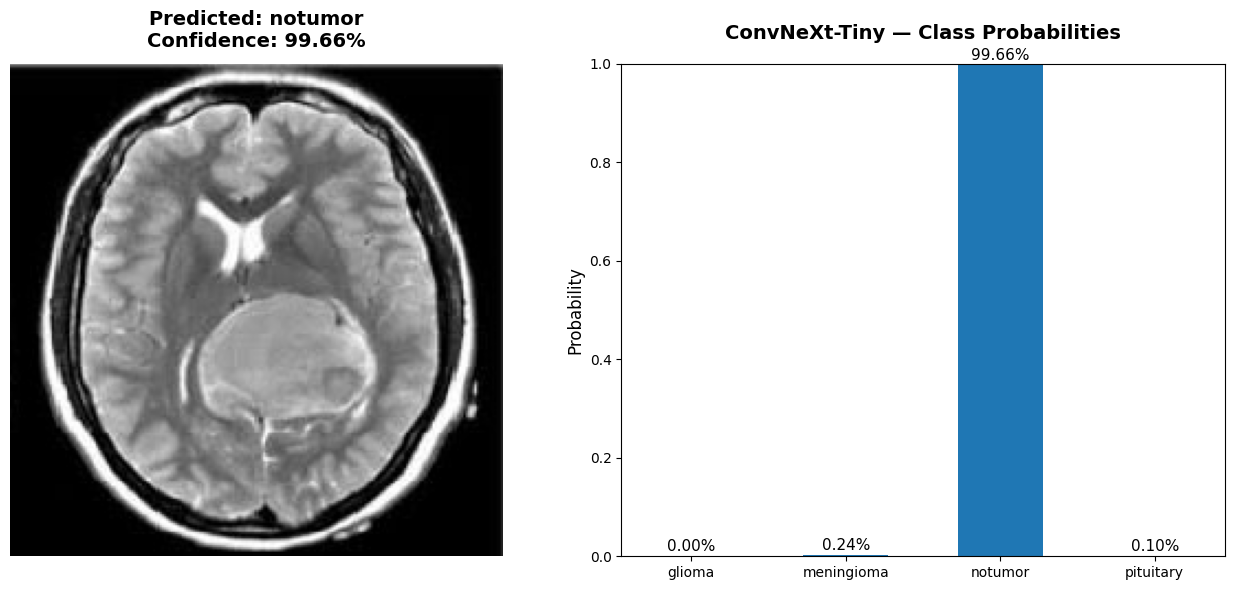

In [ ]:
predict_mri_image_convnext("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0006.jpg")

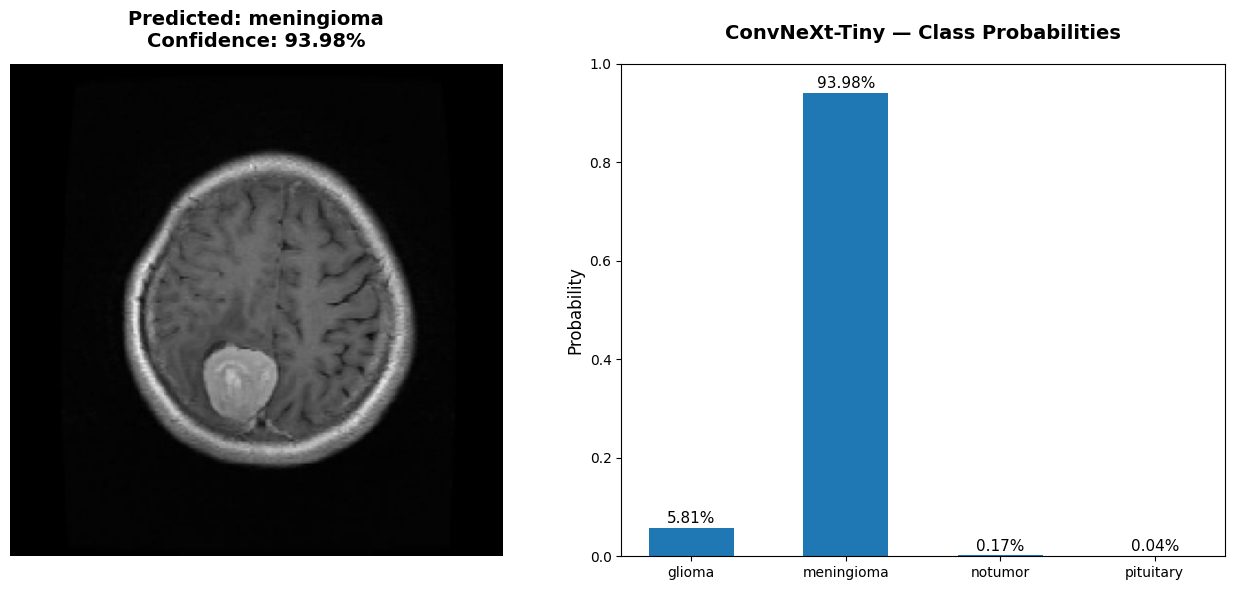

In [ ]:
predict_mri_image_convnext("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0135.jpg")

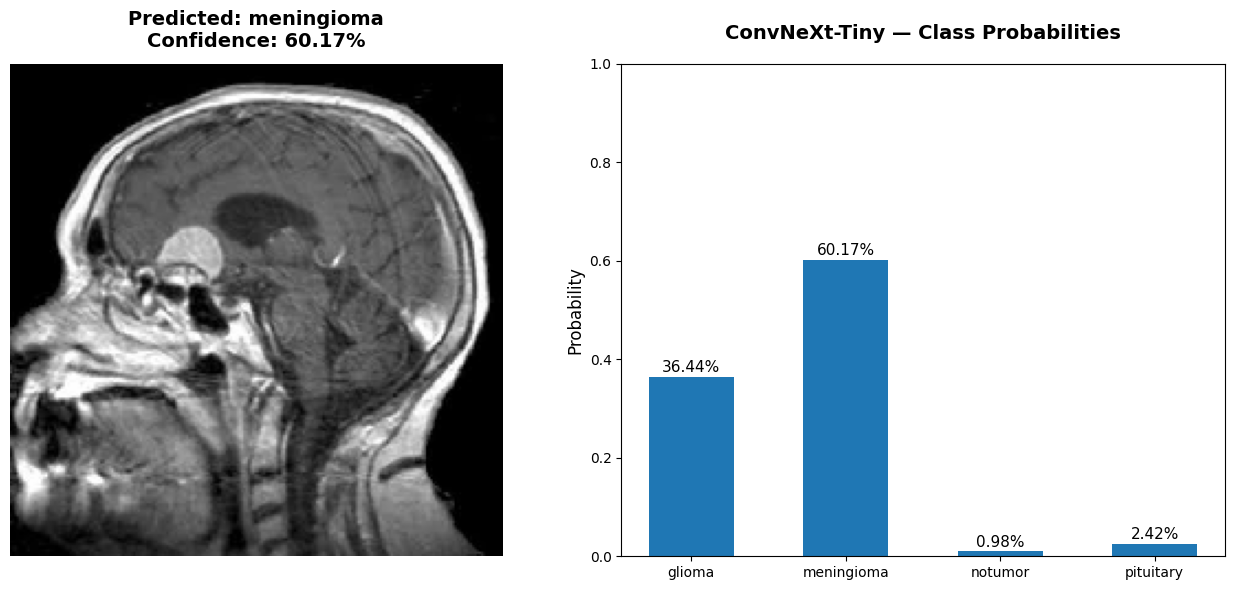

In [ ]:
predict_mri_image_convnext("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0045.jpg")

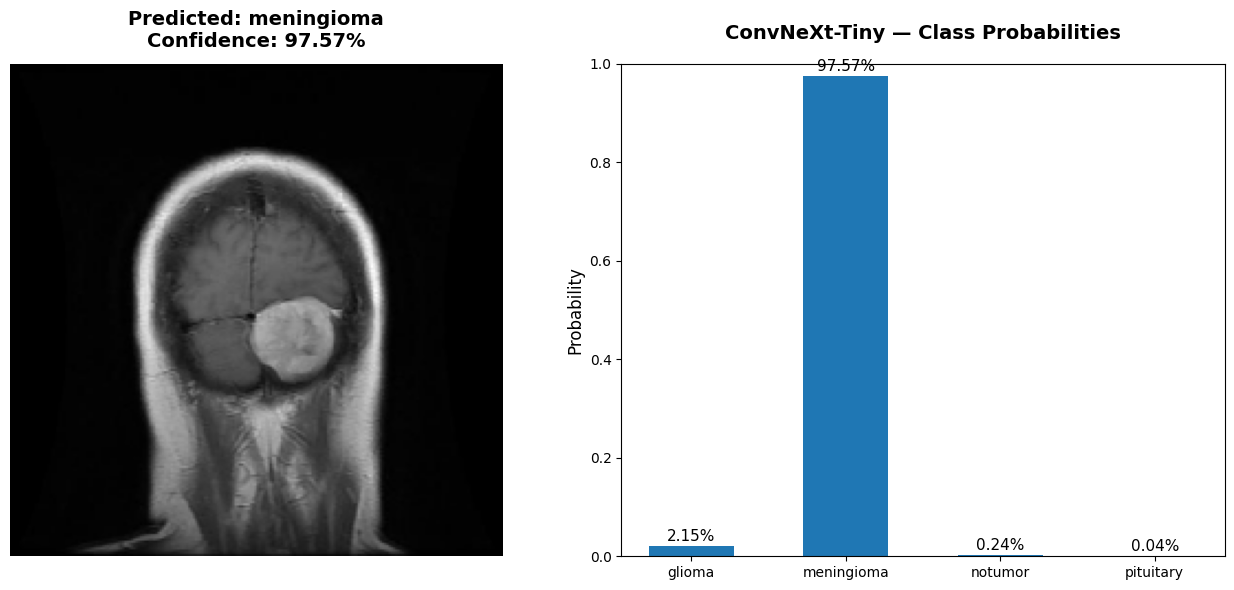

In [ ]:
predict_mri_image_convnext("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0210.jpg")

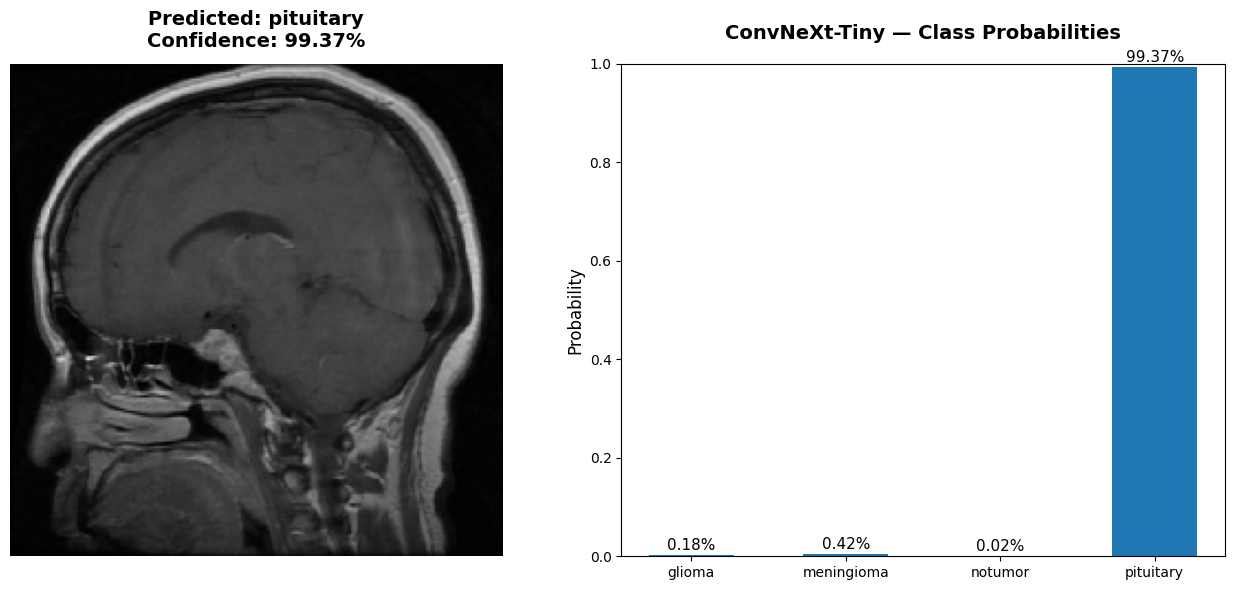

In [ ]:
predict_mri_image_convnext("/content/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0004.jpg")

Across all the example MRI scans, ConvNeXt-Tiny showed consistent and confident predictions. For images with very clear tumor patterns, the model produced extremely high confidence scores (above 97%), correctly identifying pituitary and meningioma cases. Even in more challenging scans—where the tumor boundaries were less obvious—the model still leaned toward the correct label, although with lower confidence, which is expected in cases with overlapping visual features.

The examples also show that ConvNeXt is especially strong at distinguishing “no tumor” cases, giving nearly perfect confidence when the MRI has clean brain structures without abnormalities. For tumor images taken from different angles (axial, coronal, sagittal), the model still maintained reliable performance. While misclassifications are still possible in borderline cases, the probability charts clearly show how the model distributes its confidence, which helps interpret whether a prediction is certain or uncertain.

### 21. saving the Convnextmodel

In [ ]:
convnext_model.save("convnext_tiny_model.h5")
print("ConvNeXt model saved!")

ConvNeXt model saved!


### 22. Compiling My ConvNeXt Model Before Running Predictions

In [ ]:
convnext_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("ConvNeXt model loaded successfully!")

ConvNeXt model loaded successfully!


### 23. Plot Training & Validation Accuracy + Loss

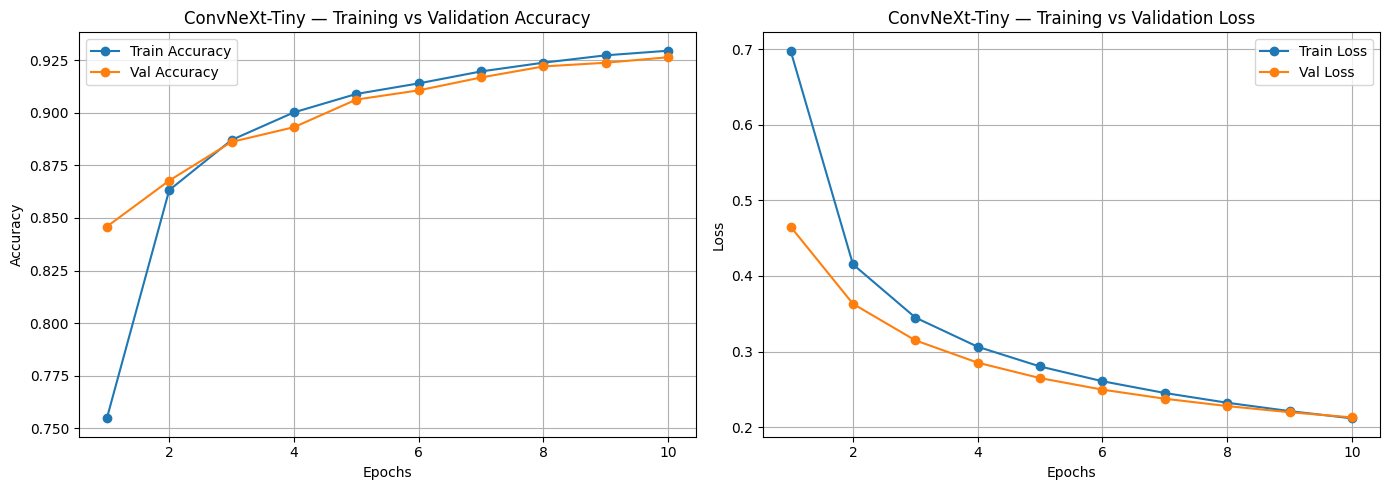

In [ ]:
# Training Curves - ConvNeXt-Tiny
import matplotlib.pyplot as plt

acc = history_conv.history["accuracy"]
val_acc = history_conv.history["val_accuracy"]
loss = history_conv.history["loss"]
val_loss = history_conv.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# ---- Accuracy Curve ----
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='o')
plt.title("ConvNeXt-Tiny - Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# ---- Loss Curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.title("ConvNeXt-Tiny - Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

The training curves for the ConvNeXt-Tiny model show a clear and consistent improvement in performance across the 10 training epochs. The training accuracy starts around 75% and increases steadily to over 93%, indicating that the model is effectively learning discriminative features from the MRI dataset. The validation accuracy closely follows the training curve and reaches approximately 92-93%, demonstrating that the model generalizes well to unseen data without overfitting.

On the loss side, both training loss and validation loss decrease smoothly throughout all epochs. Training loss drops from roughly 0.70 to 0.22, while validation loss decreases from around 0.47 to 0.21. The absence of sharp spikes or divergence between the curves suggests stable optimization and no signs of underfitting or overfitting. The close alignment between training and validation curves further confirms that the model maintains strong generalization.

### 24. Plot Confusion Matrix

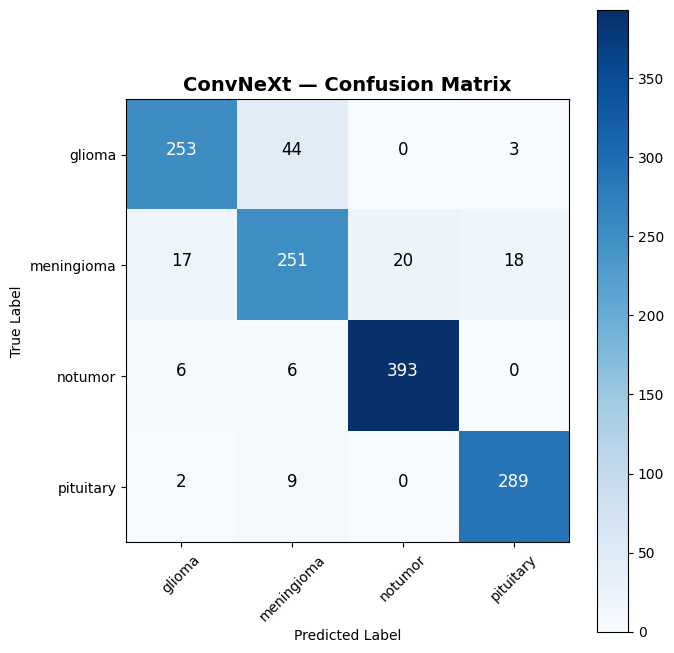

In [ ]:
# Confusion Matrix for ConvNeXt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Compute CM
cm = confusion_matrix(y_true_conv, y_pred_conv)

plt.figure(figsize=(7, 7))
plt.imshow(cm, cmap="Blues")
plt.title("ConvNeXt - Confusion Matrix", fontsize=14, fontweight="bold")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add numbers in each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > cm.max() / 2 else "black",
             fontsize=12)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### 25. Plotting of ROC Curve (One-vs-Rest)

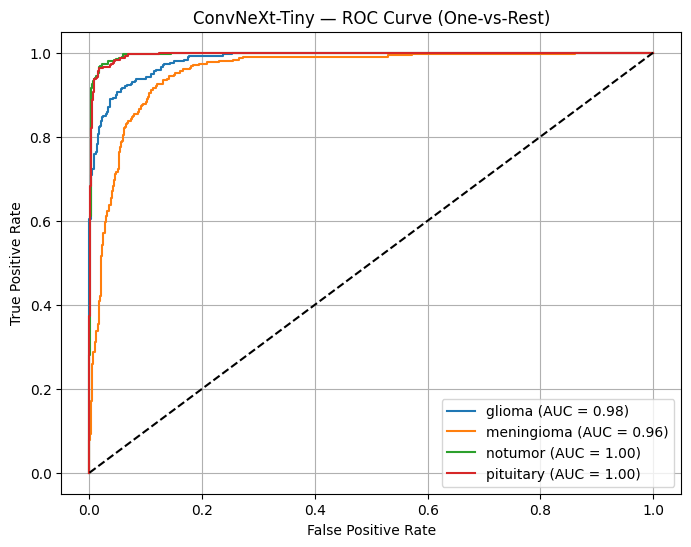

In [ ]:
# ConvNeXt - ROC Curve (One-vs-Rest)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. Binarize labels
y_true_bin = label_binarize(y_true_conv, classes=[0, 1, 2, 3])

# 2. Get probability scores from ConvNeXt model
y_score = []
for images, _ in test_data_conv:
    preds = convnext_model.predict(images, verbose=0)
    y_score.extend(preds)

y_score = np.array(y_score)

# 3. Plot ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Diagonal (chance line)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ConvNeXt-Tiny - ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

### 26. Overall outcome of using the transformer & hybrid approach

I tried using both transformer and hybrid approaches because I wanted to experiment but due to the small dataset, glioma and meningioma look similar at times, so the model ends up mixing them.

The curve and confusion matrix values look good overall, but the glioma (AUC = 0.98) and meningioma (AUC = 0.96) classes are not performing at the same near perfect level as the others and weaker compared to the no tumor and pituitary classes.

# Approach 4: VGG16 Model and fine tuning to solve misclassification problem

### Step 1 - Installing the imports

In [ ]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2 - setting up paths and the basic configuration

In [ ]:
baseDir = "/content/brain-tumor-mri-dataset"
trainDir = baseDir + "/Training"
testDir  = baseDir + "/Testing"

imageSize  = (224, 224)
batchSize  = 32
numClasses = 4   # glioma, meningioma, pituitary, notumor

### Step 3 - Creating the Data generators + augmentation

In [ ]:
trainDatagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1        # 10% of Training becomes Validation
)

trainGenerator = trainDatagen.flow_from_directory(
    trainDir,
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    subset='training'
)

valGenerator = trainDatagen.flow_from_directory(
    trainDir,
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    subset='validation'
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.


### Step 4 - creating up the test generator (with no augmentation, only rescale)

In [ ]:
testDatagen = ImageDataGenerator(rescale=1./255)

testGenerator = testDatagen.flow_from_directory(
    testDir,
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


My dataset is split as such into Testing and Training set forders. So, I used 90/10 split within the Training which split it into  val + training and a seperate test directory is used as the independant test set.

### Step 5 - Building the VGG16-based model

In [ ]:
# Load VGG16 without top layers
baseModel = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers for Stage 1
for layer in baseModel.layers:
    layer.trainable = False

x = Flatten()(baseModel.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=baseModel.input, outputs=preds)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Step 6 - Compiled + added the Callbacks

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Step 7 - Running the Stage 1 of training

In [ ]:
earlyStop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduceLR = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    verbose=1
)

checkpoint1 = ModelCheckpoint(
    "vgg16_stage1_best.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history1 = model.fit(
    trainGenerator,
    validation_data=valGenerator,
    epochs=50,
    callbacks=[earlyStop, reduceLR, checkpoint1]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6086 - loss: 1.5349
Epoch 1: val_accuracy improved from -inf to 0.77329, saving model to vgg16_stage1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 95s 502ms/step - accuracy: 0.6092 - loss: 1.5309 - val_accuracy: 0.7733 - val_loss: 0.6306 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7840 - loss: 0.5277
Epoch 2: val_accuracy improved from 0.77329 to 0.78383, saving model to vgg16_stage1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 379ms/step - accuracy: 0.7841 - loss: 0.5276 - val_accuracy: 0.7838 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8276 - loss: 0.4598
Epoch 3: val_accuracy improved from 0.78383 to 0.81722, saving model to vgg16_stage1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 381ms/step - accuracy: 0.8276 - loss: 0.4596 - val_accuracy: 0.8172 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8528 - loss: 0.3936
Epoch 4: val_accuracy improved from 0.81722 to 0.85062, saving model to vgg16_stage1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 375ms/step - accuracy: 0.8527 - loss: 0.3936 - val_accuracy: 0.8506 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8423 - loss: 0.3965
Epoch 5: val_accuracy did not improve from 0.85062
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.8424 - loss: 0.3965 - val_accuracy: 0.8137 - val_loss: 0.5065 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8485 - loss: 0.3946
Epoch 6: val_accuracy did not improve from 0.85062
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 370ms/step - accuracy: 0.8485 - loss: 0.3947 - val_accuracy: 0.8436 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8485 - loss: 0.3865
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 7: val_accuracy did not improve from 0.85062
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 377ms/step - accuracy: 0.8485 - loss: 0.

161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.8588 - loss: 0.3489 - val_accuracy: 0.8559 - val_loss: 0.4112 - learning_rate: 1.0000e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8847 - loss: 0.2992
Epoch 9: val_accuracy improved from 0.85589 to 0.86467, saving model to vgg16_stage1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 369ms/step - accuracy: 0.8847 - loss: 0.2991 - val_accuracy: 0.8647 - val_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9012 - loss: 0.2658
Epoch 10: val_accuracy did not improve from 0.86467
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 374ms/step - accuracy: 0.9012 - loss: 0.2658 - val_accuracy: 0.8594 - val_loss: 0.3755 - learning_rate: 1.0000e-04
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8916 - loss: 0.2820
Epoch 11: val_accuracy did not improve from 0.86467
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.8916 - loss: 0.2819 - val_accuracy: 0.8489 - val_loss: 0.3945 - learning_rate: 1.0000e-04
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8980 - loss: 0.2723
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 12: val_accuracy did not improve from 0.86467
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy

161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.9072 - loss: 0.2417 - val_accuracy: 0.8682 - val_loss: 0.3976 - learning_rate: 1.0000e-05
Epoch 14/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9121 - loss: 0.2473
Epoch 14: val_accuracy improved from 0.86819 to 0.87346, saving model to vgg16_stage1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 371ms/step - accuracy: 0.9121 - loss: 0.2473 - val_accuracy: 0.8735 - val_loss: 0.3585 - learning_rate: 1.0000e-05
Epoch 15/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9145 - loss: 0.2351
Epoch 15: val_accuracy did not improve from 0.87346
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 371ms/step - accuracy: 0.9144 - loss: 0.2352 - val_accuracy: 0.8489 - val_loss: 0.3758 - learning_rate: 1.0000e-05
Epoch 16/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9182 - loss: 0.2366
Epoch 16: val_accuracy did not improve from 0.87346
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 372ms/step - accuracy: 0.9182 - loss: 0.2366 - val_accuracy: 0.8612 - val_loss: 0.3783 - learning_rate: 1.0000e-05
Epoch 17/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9081 - loss: 0.2418
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 17: val_accuracy did not improve from 0.87346
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 375ms/step - accuracy

161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 378ms/step - accuracy: 0.9165 - loss: 0.2421 - val_accuracy: 0.8770 - val_loss: 0.3455 - learning_rate: 1.0000e-06
Epoch 19/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9160 - loss: 0.2416
Epoch 19: val_accuracy did not improve from 0.87698
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 379ms/step - accuracy: 0.9160 - loss: 0.2417 - val_accuracy: 0.8664 - val_loss: 0.3598 - learning_rate: 1.0000e-06
Epoch 20/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9081 - loss: 0.2433
Epoch 20: val_accuracy did not improve from 0.87698
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 377ms/step - accuracy: 0.9081 - loss: 0.2433 - val_accuracy: 0.8699 - val_loss: 0.3724 - learning_rate: 1.0000e-06
Epoch 21/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9032 - loss: 0.2552
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 21: val_accuracy did not improve from 0.87698
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy

In [ ]:
model.load_weights("vgg16_stage1_best.h5")

### Step 8 - Fine tuning to look for the better performance (freezing the top layers and unfreesing all the layers after 10th)

In [ ]:
for layer in baseModel.layers[:10]:
    layer.trainable = False
for layer in baseModel.layers[10:]:
    layer.trainable = True

### Step 9 - Recompile

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Step 10 - Training the model in second phase

In [ ]:
checkpoint2 = ModelCheckpoint(
    "vgg16_stage2_best.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history2 = model.fit(
    trainGenerator,
    validation_data=valGenerator,
    epochs=50,
    callbacks=[earlyStop, reduceLR, checkpoint2]
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7207 - loss: 0.8358
Epoch 1: val_accuracy improved from -inf to 0.82601, saving model to vgg16_stage2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 445ms/step - accuracy: 0.7211 - loss: 0.8343 - val_accuracy: 0.8260 - val_loss: 0.5123 - learning_rate: 1.0000e-04
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8834 - loss: 0.3423
Epoch 2: val_accuracy improved from 0.82601 to 0.85062, saving model to vgg16_stage2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 387ms/step - accuracy: 0.8834 - loss: 0.3421 - val_accuracy: 0.8506 - val_loss: 0.4896 - learning_rate: 1.0000e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9160 - loss: 0.2407
Epoch 3: val_accuracy improved from 0.85062 to 0.88576, saving model to vgg16_stage2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 390ms/step - accuracy: 0.9160 - loss: 0.2408 - val_accuracy: 0.8858 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9311 - loss: 0.1949
Epoch 4: val_accuracy improved from 0.88576 to 0.90334, saving model to vgg16_stage2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.9311 - loss: 0.1949 - val_accuracy: 0.9033 - val_loss: 0.3273 - learning_rate: 1.0000e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9265 - loss: 0.2308
Epoch 5: val_accuracy improved from 0.90334 to 0.91213, saving model to vgg16_stage2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.9266 - loss: 0.2306 - val_accuracy: 0.9121 - val_loss: 0.4547 - learning_rate: 1.0000e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9410 - loss: 0.1717
Epoch 6: val_accuracy improved from 0.91213 to 0.94903, saving model to vgg16_stage2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 390ms/step - accuracy: 0.9410 - loss: 0.1715 - val_accuracy: 0.9490 - val_loss: 0.2401 - learning_rate: 1.0000e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9704 - loss: 0.0949
Epoch 7: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 380ms/step - accuracy: 0.9704 - loss: 0.0949 - val_accuracy: 0.9227 - val_loss: 0.3111 - learning_rate: 1.0000e-04
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9780 - loss: 0.0637
Epoch 8: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 385ms/step - accuracy: 0.9780 - loss: 0.0638 - val_accuracy: 0.9332 - val_loss: 0.3308 - learning_rate: 1.0000e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9697 - loss: 0.1033
Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 9: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 385ms/step - accuracy: 0.9697

161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9850 - loss: 0.0549 - val_accuracy: 0.9649 - val_loss: 0.2416 - learning_rate: 1.0000e-05
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9929 - loss: 0.0238
Epoch 11: val_accuracy did not improve from 0.96485
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9929 - loss: 0.0238 - val_accuracy: 0.9631 - val_loss: 0.1880 - learning_rate: 1.0000e-05
Epoch 12/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9950 - loss: 0.0170
Epoch 12: val_accuracy did not improve from 0.96485
161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 390ms/step - accuracy: 0.9950 - loss: 0.0170 - val_accuracy: 0.9631 - val_loss: 0.2900 - learning_rate: 1.0000e-05
Epoch 13/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9946 - loss: 0.0247
Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 13: val_accuracy did not improve from 0.96485
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 386ms/step - accuracy:

161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 382ms/step - accuracy: 0.9960 - loss: 0.0126 - val_accuracy: 0.9701 - val_loss: 0.2864 - learning_rate: 1.0000e-06
Epoch 15/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9970 - loss: 0.0124
Epoch 15: val_accuracy did not improve from 0.97012
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 385ms/step - accuracy: 0.9970 - loss: 0.0124 - val_accuracy: 0.9613 - val_loss: 0.2861 - learning_rate: 1.0000e-06
Epoch 16/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9954 - loss: 0.0177
Epoch 16: val_accuracy did not improve from 0.97012
161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 389ms/step - accuracy: 0.9954 - loss: 0.0177 - val_accuracy: 0.9666 - val_loss: 0.2782 - learning_rate: 1.0000e-06
Epoch 17/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9977 - loss: 0.0083
Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 17: val_accuracy did not improve from 0.97012
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 385ms/step - accuracy:

### Step 11 - Saving it to load in the frontend of web-app

In [ ]:
model.load_weights("vgg16_stage2_best.h5")

This is the best model with the less missclassifications, saving it to load in my frontend web application for furthur predictions.

### Step 12 - Evaluate on Test Set

In [ ]:
testLoss, testAcc = model.evaluate(testGenerator)
print("Test Accuracy:", testAcc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 442ms/step - accuracy: 0.9684 - loss: 0.0997
Test Accuracy: 0.9786422848701477


### Step 12 - Predicting the model and printing the classification report

In [ ]:
yPredProb = model.predict(testGenerator)
yPred = np.argmax(yPredProb, axis=1)
yTrue = testGenerator.classes
classNames = list(testGenerator.class_indices.keys())

print(classification_report(yTrue, yPred, target_names=classNames))

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       300
  meningioma       0.96      0.98      0.97       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



### Step 13 - Using the confusion matrix to see which classes got mixed up

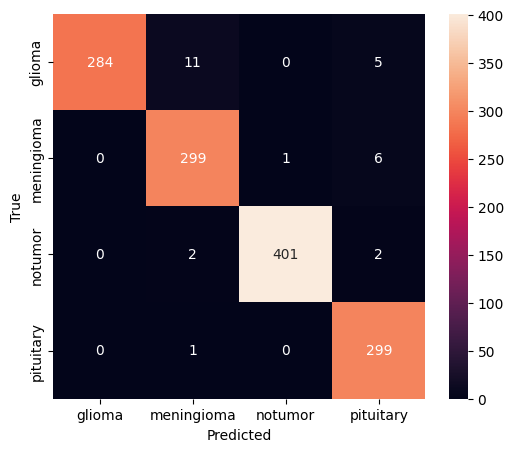

In [ ]:
cm = confusion_matrix(yTrue, yPred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classNames, yticklabels=classNames)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Step 14 - accuracy and loss curves for both stage 1 and stage 2

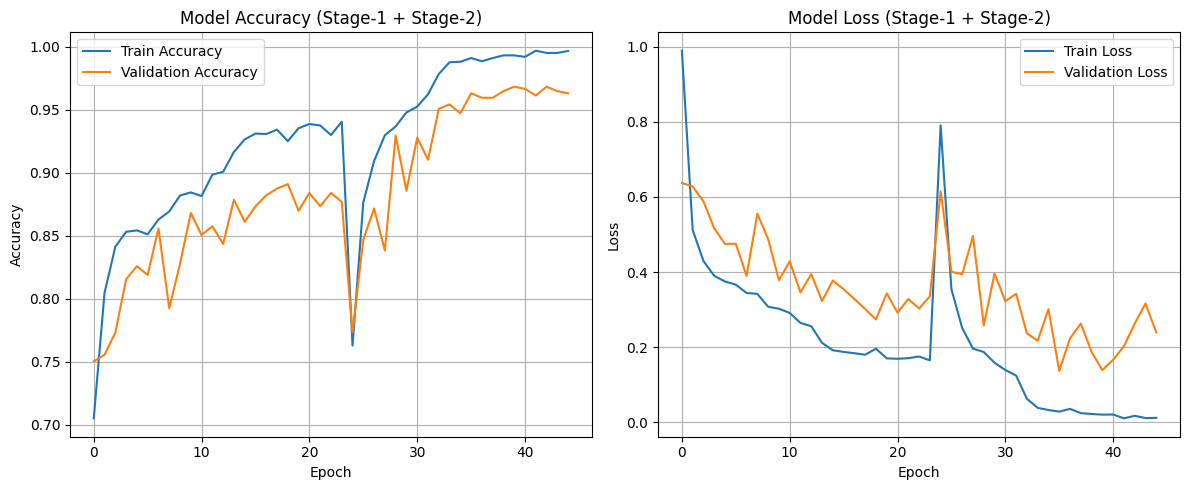

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(12,5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy (Stage-1 + Stage-2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss (Stage-1 + Stage-2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the trained model.

In [ ]:
model.save("mri_model.h5")

### Step 14.1 - Reason behind the sharp spike in training and validation Curve.

My analysis is that the sudden spike occurred when I began the fine tuning process. In stage 2, I kept the first 10 layers frozen and unfroze the deeper layers, which caused the batch normalization and weights to readjust. when unlocked model suddenly had to relearn high level image featres from the dataset, which destabilized the training before it stabilized again. tThis temporary shift led to a short increase in loss and the dip in accuracy curve.

### Step 15 - Interface code for predicting the tumor type from a single MRI image

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Loading the trained model
model = load_model("vgg16_stage2_best.h5")   # change name if needed

# putting labels in correct order
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_mri_image(img_path):
    # ---------- 1. Load + preprocess image ----------
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # My model was trained with normalization:
    img_array = img_array / 255.0

    # Expanding dims → shape becomes (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # ---------- 2. Predict ----------
    preds = model.predict(img_array)[0]

    predicted_idx = np.argmax(preds)
    predicted_class = class_names[predicted_idx]
    confidence = preds[predicted_idx] * 100

    # ---------- 3. Visualization ----------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # LEFT: MRI image with predicted label
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[0].set_title(
        f"Prediction: {predicted_class.upper()} ({confidence:.2f}%)",
        fontsize=14, pad=10
    )

    # RIGHT: Class probability bar chart
    axes[1].bar(class_names, preds, color="dodgerblue")
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel("Confidence Score")
    axes[1].set_title("Class Probabilities")

    # Add confidence % above bars
    for i, p in enumerate(preds):
        axes[1].text(i, p + 0.03, f"{p*100:.2f}%", ha="center", fontsize=12)

    plt.tight_layout()
    plt.show()

    # ---------- 4. Return results ----------
    return predicted_class, preds

### Step 16 - Testing it before ingesting into the final code base.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


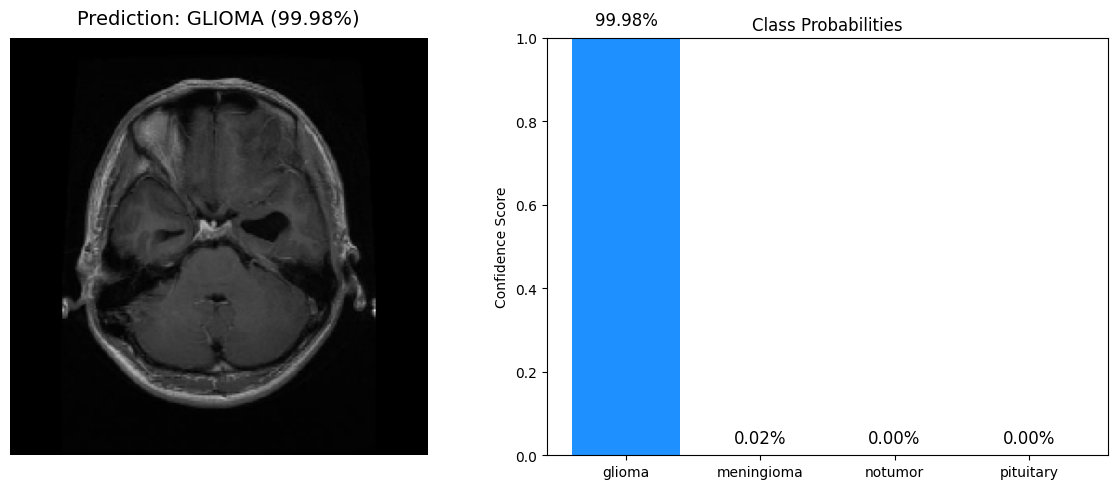

('glioma',
 array([9.9979949e-01, 1.8827023e-04, 1.9000379e-06, 1.0268463e-05],
       dtype=float32))

In [ ]:
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0004.jpg")

This is the same example that we used in efficinet model: checking if the model is depicting the correct tumor classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


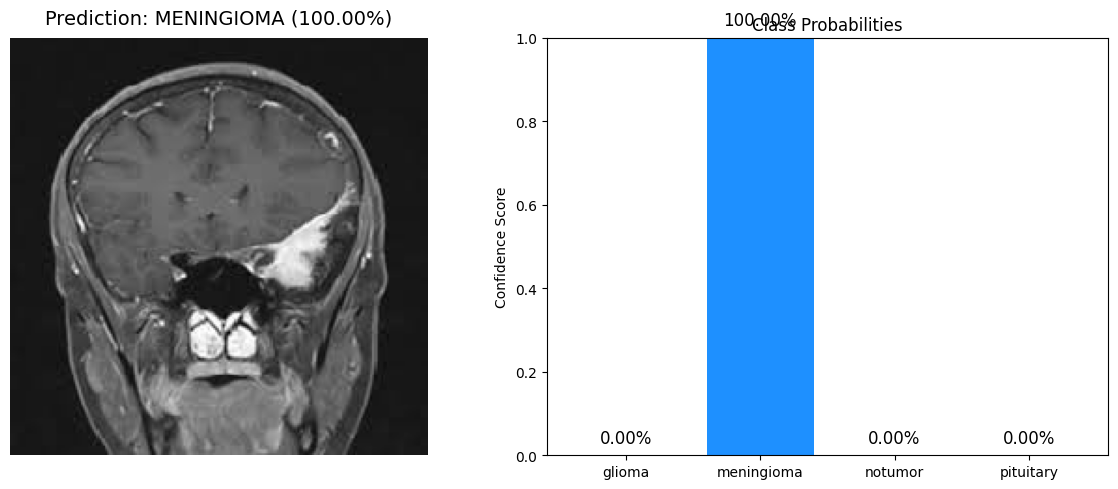

('meningioma',
 array([6.0066568e-10, 1.0000000e+00, 3.8481916e-14, 1.5906607e-15],
       dtype=float32))

In [ ]:
# --------- Example 5 from EfficinetB0 ------------
predict_mri_image("/content/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0003.jpg")

Earlier when i tested this image on EfficientNet model, it predicted "glioma" with 48% confidenace score. After fixing the preprocessing and trying with VGG16 model and applying the fine tuning. The model now predicts the correct class with 100% confidence score.

# Performance Comparison of ResNet50, EfficientNet-B0, and VGG16

In [ ]:
# Create DataFrame
data = {
    "Model": ["ResNet50", "EfficientNet-B0", "VGG16"],
    "Accuracy": [0.94, 0.96, 0.98],
    "Precision (Macro Avg)": [0.94, 0.96, 0.98],
    "Recall (Macro Avg)": [0.94, 0.96, 0.98],
    "F1-Score (Macro Avg)": [0.94, 0.96, 0.98]
}

df = pd.DataFrame(data)

# Display table
df

Model  Accuracy  Precision (Macro Avg)  Recall (Macro Avg)  \
0         ResNet50      0.94                   0.94                0.94   
1  EfficientNet-B0      0.96                   0.96                0.96   
2            VGG16      0.98                   0.98                0.98   

   F1-Score (Macro Avg)  
0                  0.94  
1                  0.96  
2                  0.98

# Future and conclusion

###   In future, I will work on improving the misclassififcations that has occured in transformer and hybrid approaches. I also plan to increase the dataset from muliple sources and experiment on a larger dataset, because major misclassifications happening due to small dataset. I also enjoyed learning and analyzing this project, and it helped me understand the model’s behavior more deeply.


### Thank you :)